In [2]:
# %pip -q install --upgrade pip
# %pip -q install vaex scikit-learn control pymoo salib 'numpy<=1.26' matplotlib pandas scipy sympy scienceplots

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

Train size ≃ 3.28%
Test size ≃ 96.72%


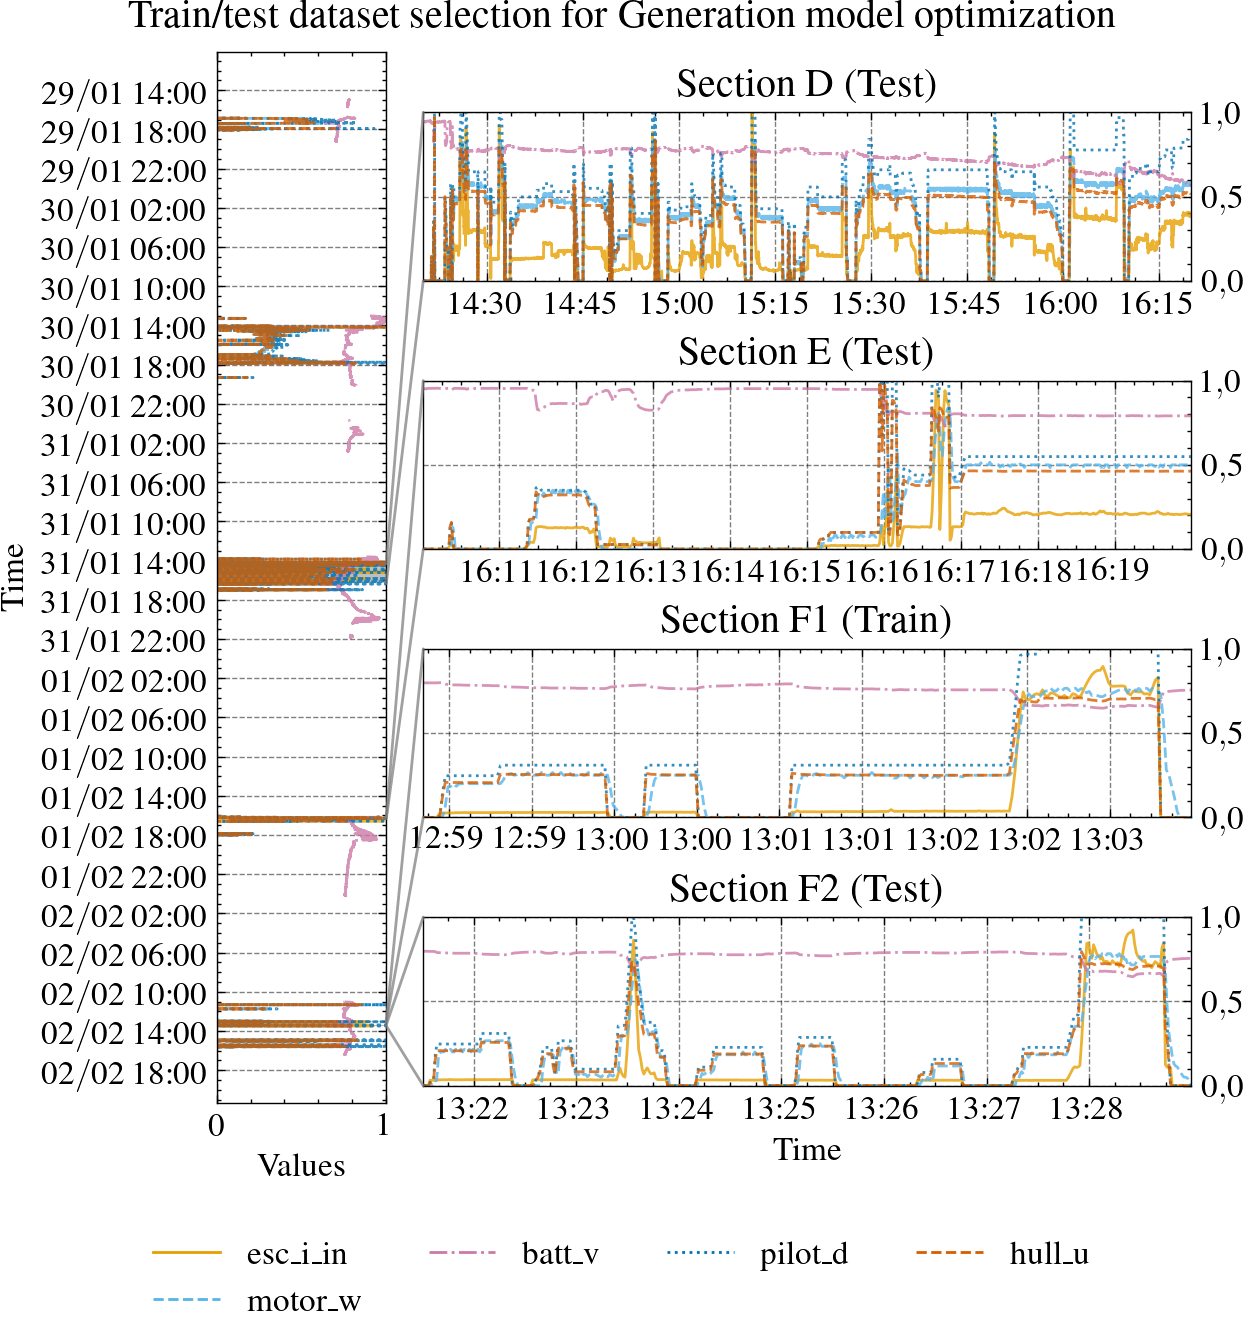

In [4]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    # 'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'pilot_d',
    'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    # 'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}

df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
)

sections, tzinfo = get_sections()

# Customizing ranges:
sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F1', 'Section F2']]

# train_section_name = 'Section D'
train_section_name = 'Section F1'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')


def boat_speed_from_motor_v(motor_v, a=0.54340307/3.6):
    return a*motor_v  # [m/s]

df['hull_u'] = boat_speed_from_motor_v(df['batt_v']*df['pilot_d'])

fig_save_and_show(
        filename=None,#f'{latex_img_path}/generation_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['esc_i_in', 'motor_w', 'batt_v', 'pilot_d', 'hull_u'],
            normalize=True,
        )
    )


# Propulsion System model

In [5]:
import control as ct
import math
from scipy.optimize import fsolve
import numpy as np

def eval_poly(coeffs, x):
    coeffs = list(coeffs)
    if len(coeffs) == 0:
        return 0.0
    if len(coeffs) == 1:
        return coeffs[0]

    result = 0.0
    for c in reversed(coeffs[1:]):
        result = result * x + c
    return result * x + coeffs[0]

from scipy.special import expit

class Propulsion:
    @classmethod
    def _aux(cls, t, x, u, params: dict):
        # Params
        rho_water = params['rho_water']
        prop_D = params['prop_D']
        prop_I_r = params['prop_I_r']
        prop_k_T_coeffs = params['prop_k_T_coeffs']
        prop_k_Q_coeffs = params['prop_k_Q_coeffs']
        rho_air = params['rho_air']
        hull_S_water = params['hull_S_water']
        hull_S_air = params['hull_S_air']
        hull_C_T = params['hull_C_T']
        prop_eta_R = params['prop_eta_R']
        hull_W = params['hull_W']
        hull_T_ded = params['hull_T_ded']
        trans_k = params['trans_k']
        trans_I_r_out = params['trans_I_r_out']
        trans_I_r_in = params['trans_I_r_in']
        trans_eta = params['trans_eta']

        # Inputs
        batt_v = u[0]  # Battery voltage [V]
        # pilot_d = u[1]  # Pilot duty-cycle [unitless]

        # States
        # motor_i = x[0]  # Motor current [A]
        motor_w = x[1]  # Motor angular speed [rad/s]
        esc_d = x[2]    # ESC duty-cycle [unitless]
        hull_u = x[3]   # Hull speed [m/s]
    
        eps = 1e-6
        motor_I_r_load = trans_I_r_in + trans_k**2*(prop_I_r + trans_I_r_out)
        motor_v = esc_d*batt_v
        prop_n = (1/2)*trans_k*motor_w/math.pi
        prop_j = max(0, min((1 - hull_W)*hull_u/(prop_D*(prop_n + eps)), 1.5))
        prop_k_t_ow = max(0, eval_poly(prop_k_T_coeffs, prop_j))
        prop_k_q_ow = max(0, eval_poly(prop_k_Q_coeffs, prop_j))
        prop_t = prop_D**4*rho_water*prop_k_t_ow*prop_n**2
        prop_q = prop_D**5*rho_water*prop_k_q_ow*prop_n**2/prop_eta_R
        hull_r_t = (1/2)*hull_C_T*(hull_S_air*rho_air + hull_S_water*rho_water)*hull_u**2
        hull_r = -hull_r_t/(hull_T_ded - 1)
        motor_q_load = trans_k*prop_q/trans_eta

        return motor_I_r_load, motor_v, motor_q_load, esc_d, prop_j, prop_k_q_ow, prop_k_t_ow, prop_q, prop_t, hull_u, hull_r

    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # X0 may include known initial states; here we solve for all
        X_guess = [50, 1000, 0.5, 0]  # [motor_i, motor_w, esc_d, hull_u]

        # Params
        motor_B = params['motor_B']
        motor_K_Q = params['motor_K_Q']
        motor_R_A = params['motor_R_A']

        # Inputs: [batt_v, pilot_d]
        # batt_v_0 = U0[0]  # Battery Voltage [V]
        pilot_d_0 = U0[1]  # Pilot duty-cycle

        def equations(X):
            motor_i_0, motor_w_0, esc_d_0, hull_u_0 = X

            # Outputs
            temp_x = np.array([motor_i_0, motor_w_0, esc_d_0, hull_u_0])
            temp_u = U0
            y = cls._outputs(0, temp_x, temp_u, params)
            motor_v_0 = y[0]  # Initial Motor voltage [V]
            motor_q_load_0 = y[3]  # Initial Motor torque [Nm]

            motor_i_0_calc = (motor_B * motor_v_0 + motor_K_Q * motor_q_load_0) / motor_B * motor_R_A + motor_K_Q**2
            motor_w_0_calc = (motor_K_Q * motor_v_0 - motor_R_A * motor_q_load_0) / motor_B * motor_R_A + motor_K_Q**2
            esc_d_0_calc = pilot_d_0
            hull_u_0_calc = 0.0  # assume start from rest

            return [
                motor_i_0 - motor_i_0_calc,
                motor_w_0 - motor_w_0_calc,
                esc_d_0 - esc_d_0_calc,
                hull_u_0 - hull_u_0_calc,
            ]

        solution = fsolve(equations, X_guess, xtol=1e-10)
        motor_i_0, motor_w_0, esc_d_0, hull_u_0 = solution
        return np.array([motor_i_0, motor_w_0, esc_d_0, hull_u_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        hull_M = params['hull_M']
        hull_M_a = params['hull_M_a']
        motor_R_A = params['motor_R_A']
        motor_L_A = params['motor_L_A']
        motor_K_Q = params['motor_K_Q']
        motor_K_V = params['motor_K_V']
        motor_I_r = params['motor_I_r']
        motor_B = params['motor_B']
        esc_tau_rise = params['esc_tau_rise']
        esc_tau_fall = params['esc_tau_fall']

        # Inputs
        # batt_v = u[0]  # Battery voltage [V]
        pilot_d = u[1]  # Pilot duty-cycle [unitless]

        # States
        motor_i = x[0]  # Motor current [A]
        motor_w = x[1]  # Motor angular speed [rad/s]
        esc_d = x[2]    # ESC duty-cycle [unitless]
        hull_u = x[3]   # Hull speed [m/s]

        # Auxiliars
        A = cls._aux(t, x, u, params)
        motor_I_r_load = A[0]
        motor_v = A[1]
        motor_q_load = A[2]
        prop_t = A[8]
        hull_r = A[10]

        # State derivatives
        d_motor_i = (-motor_K_V*motor_w - motor_R_A*motor_i + motor_v)/motor_L_A
        d_motor_w = (-motor_B*motor_w + motor_K_Q*motor_i - motor_q_load)/(motor_I_r + motor_I_r_load)
        d_esc_d = (((-esc_d + pilot_d)/esc_tau_rise) if (esc_d < pilot_d) else ((-esc_d + pilot_d)/esc_tau_fall))
        d_hull_u = (-hull_r + prop_t)/(hull_M + hull_M_a)

        return np.array([d_motor_i, d_motor_w, d_esc_d, d_hull_u])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        trans_k = params['trans_k']
        esc_F_s = params['esc_F_s']
        esc_V_ds_ov = params['esc_V_ds_ov']
        esc_R_ds_on = params['esc_R_ds_on']
        esc_E_on = params['esc_E_on']
        esc_E_off = params['esc_E_off']
        esc_V_F = params['esc_V_F']
        esc_r_D = params['esc_r_D']
        esc_Q_rr = params['esc_Q_rr']
        
        # Inputs
        batt_v = u[0]
        # pilot_d = u[1]

        # States
        motor_i = x[0]  # Motor current [A]
        motor_w = x[1]  # Motor angular speed [rad/s]
        esc_d = x[2]  # ESC duty-cycle [unitless]
        hull_u = x[3]  # Hull speed [m/s]

        # Auxiliars
        A = cls._aux(t, x, u, params)
        motor_v = A[1]
        motor_q_load = A[2]
        esc_d = A[3]
        prop_j = A[4]
        prop_k_q_ow = A[5]
        prop_k_t_ow = A[6]
        prop_q = A[7]
        prop_t = A[8]
        hull_u = A[9]
        hull_r = A[10]

        prop_w = trans_k*motor_w

        # Output equations
        esc_i_in = (esc_F_s*esc_Q_rr*(esc_V_ds_ov + 1)*batt_v + esc_F_s*(esc_E_off + esc_E_on)*(esc_V_ds_ov + 1) + esc_R_ds_on*esc_d*motor_i**2 - esc_V_F*(esc_d - 1)*motor_i - esc_r_D*(esc_d - 1)*motor_i**2 + esc_d*motor_i*batt_v)/batt_v

        return np.array([
            motor_v,        # 0: motor terminal voltage [V]
            motor_w,        # 1: motor angular speed [rad/s]
            motor_i,        # 2: motor current [A]
            motor_q_load,   # 3: motor load torque [N·m]
            esc_d,          # 4: ESC duty-cycle [-]
            esc_i_in,       # 5: ESC input current (DC bus) [A]
            prop_w,         # 6: Propeller angular speed [rad/s]
            prop_j,         # 7: J (self-propelled) = V / (ω D)
            prop_k_q_ow,    # 8: behind-ship torque coeff K_Q(J, η_R)
            prop_k_t_ow,    # 9: behind-ship thrust coeff K_T(J)
            prop_q,         # 10: prop torque [N·m]
            prop_t,         # 11: prop thrust [N]
            hull_u,         # 12: hull speed [m/s]
            hull_r,         # 13: hull resistance [N]
        ])

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='propulsion',
            states=('motor_i', 'motor_w', 'esc_d', 'hull_u'),
            inputs=('batt_v', 'pilot_d'),
            outputs=('motor_v', 'motor_w', 'motor_i', 'motor_q_load', 'esc_d', 'esc_i_in', 'prop_w', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r'),
            params=params,
        )

Propulsion.build({})

<NonlinearIOSystem propulsion: ['batt_v', 'pilot_d'] -> ['motor_v', 'motor_w', 'motor_i', 'motor_q_load', 'esc_d', 'esc_i_in', 'prop_w', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']>

In [6]:
def get_hull_areas(hull_M, hull_cog_x, hull_S_total=8.2379):
    sys.path.append('../')
    from hull.hydrostatic_hull import HydrostaticHull

    assert hull_S_total > 0

    hull = HydrostaticHull()
    hull_S_water = hull.wet_surface_area(hull_cog_x, hull_M)
    hull_S_air = hull_S_total - hull_S_water

    assert hull.is_in_valid_range(hull_cog_x, hull_M)
    assert hull_S_water > 0
    assert hull_S_air > 0

    return (hull_S_water, hull_S_air)

hull_M = 293.7 # [kg]
hull_S_water, hull_S_air = get_hull_areas(hull_M, hull_cog_x=1.9760, hull_S_total=8.2379)

propulsion_params = {
    # From models/2020/Motor/me0909_free_rotor_step.ipynb:
    'motor_R_A': 0.019579524515654242,
    'motor_B': 0.0012793008044770459,
    'motor_K_Q': 0.10543193741528227,
    'motor_K_V': 0.10337093946599393,
    'motor_L_A': 6.336356266841513e-05,
    'motor_I_r': 0.011828773027862982,
    'rho_water': 1023,  # Estimated from public ocean dataset
    'rho_air': 1.1839,  # Estimated from public ocean dataset

    # From models/2020/esc/mam17_pymoo.ipynb:
    'esc_F_s': 12550,
    'esc_V_ds_ov': 2.0,
    'esc_R_ds_on': 0.008256754167097705,
    'esc_E_on': 7e-05,
    'esc_E_off': 0.00011,
    'esc_V_F': 3.338359854985,
    'esc_r_D': 0.004027165799996619,
    'esc_Q_rr': 1.9e-07,

    # Others
    'esc_tau_fall': 0.5,  # Unknown
    'esc_tau_rise': 1.5,  # Unknown
    'trans_eta': 0.9,  # Arbitrary
    'trans_I_r_in': 0,  # Ignored
    'trans_I_r_out': 0,  # Ignored
    'trans_k': 14/22,  # Manually counted
    'prop_D': 9.0 * 0.0254,  # From manufacturer's specs
    'prop_k_T_coeffs': np.array([ 0.37208208, -0.10825004, -0.16735476,  0.02821403]),
    'prop_k_Q_coeffs': np.array([ 0.05470368, -0.01753569, -0.00050999, -0.01078306]),
    'prop_eta_R': 1.0,  # Unknown
    'prop_I_r': 5.54e-04,  # Unknown
    'hull_C_T': 0.01,  # Unknown
    'hull_M': hull_M,  # Measured (fully loaded, with pilot)
    'hull_M_a': 0,  # Unknown
    'hull_S_water': hull_S_water,  # Estimated from hydrostatics
    'hull_S_air': hull_S_air,  # Estimated from hydrostatics
    'hull_T_ded': 0.0855,  # Estimated from models/2020/propeller/propeller.ipynb
    'hull_W': 0.1425,  # Estimated from models/2020/propeller/propeller.ipynb
}
propulsion_params

{'motor_R_A': 0.019579524515654242,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_I_r': 0.011828773027862982,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_F_s': 12550,
 'esc_V_ds_ov': 2.0,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_E_on': 7e-05,
 'esc_E_off': 0.00011,
 'esc_V_F': 3.338359854985,
 'esc_r_D': 0.004027165799996619,
 'esc_Q_rr': 1.9e-07,
 'esc_tau_fall': 0.5,
 'esc_tau_rise': 1.5,
 'trans_eta': 0.9,
 'trans_I_r_in': 0,
 'trans_I_r_out': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': array([ 0.37208208, -0.10825004, -0.16735476,  0.02821403]),
 'prop_k_Q_coeffs': array([ 0.05470368, -0.01753569, -0.00050999, -0.01078306]),
 'prop_eta_R': 1.0,
 'prop_I_r': 0.000554,
 'hull_C_T': 0.01,
 'hull_M': 293.7,
 'hull_M_a': 0,
 'hull_S_water': 4.142904990019334,
 'hull_S_air': 4.094995009980666,
 'hull_T_ded': 0.0855,
 'hull_W': 0.1425}

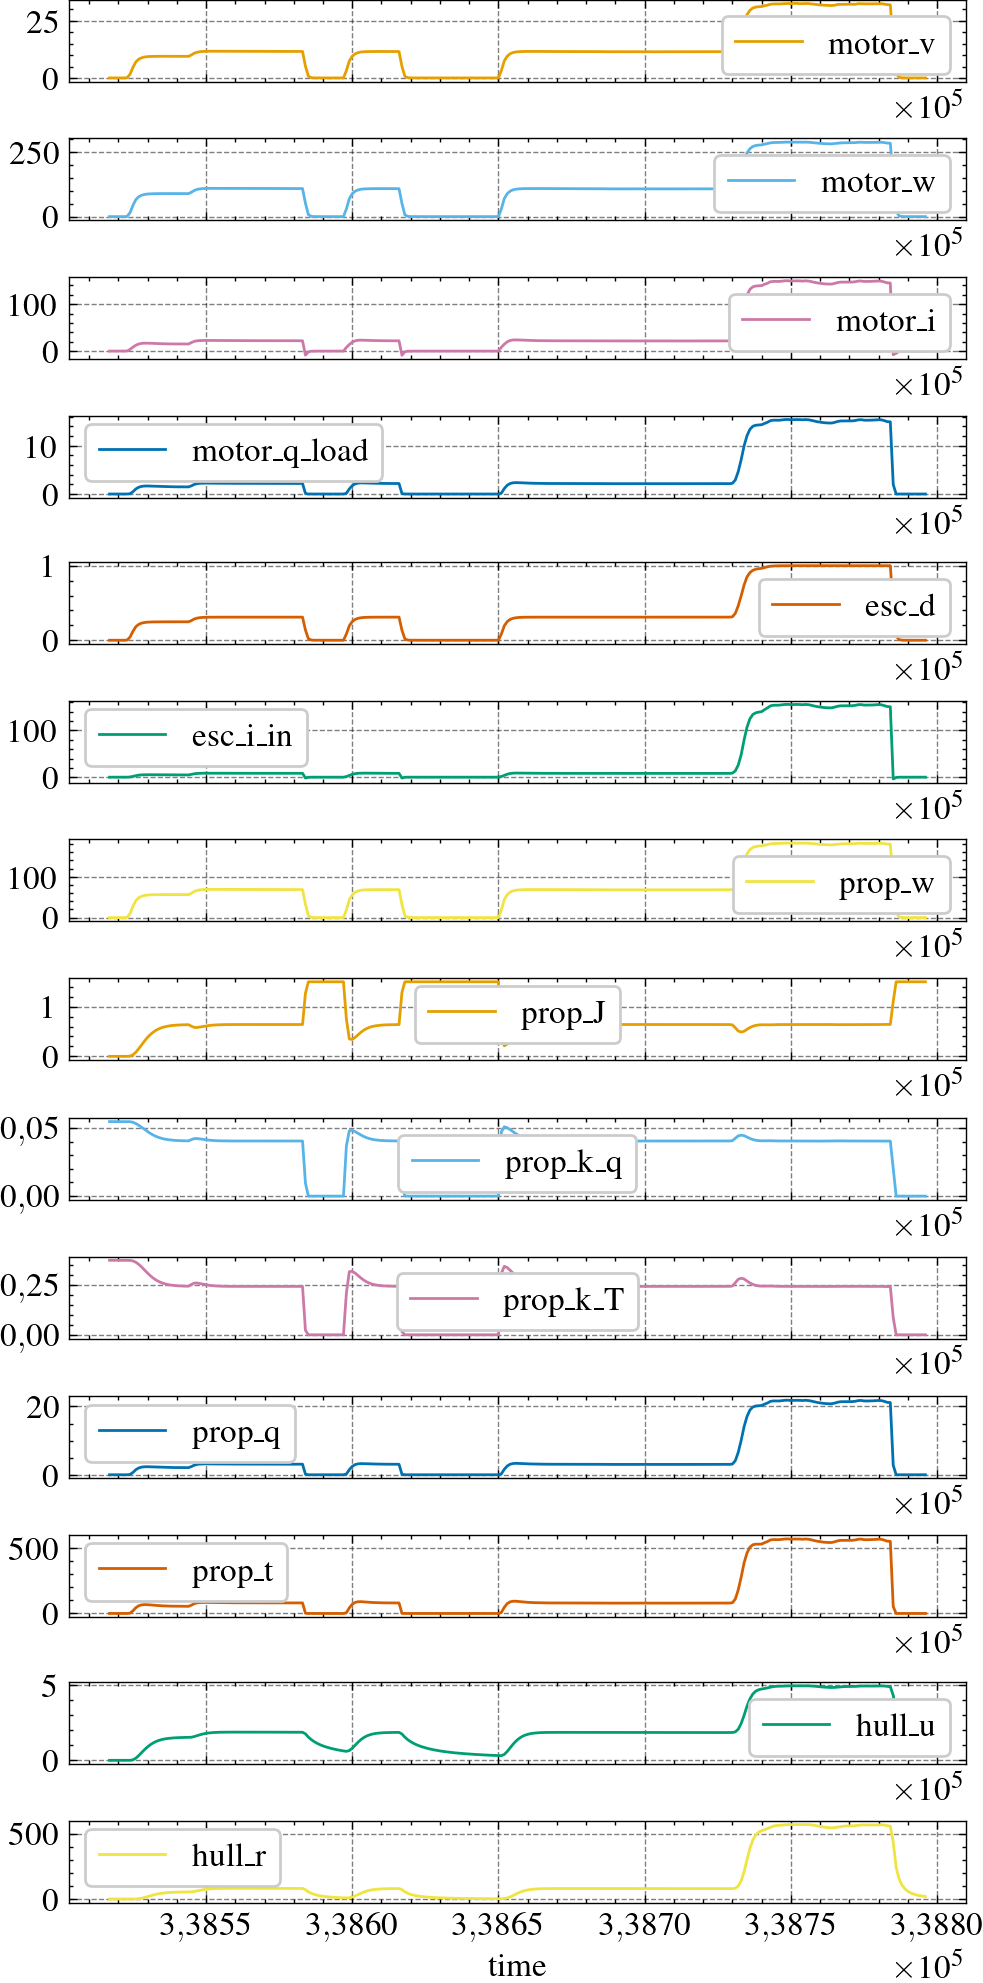

In [7]:
# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'pilot_d']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)

# Model
propulsion = Propulsion.build(propulsion_params)

# Initial state
X0 = Propulsion.initial_state(
    X0=dict(),
    U0=U[:,0],
    params=propulsion_params,
)

# Simulation
res = ct.input_output_response(propulsion, T=T, U=U, X0=X0, solve_ivp_method='Radau') # type: ignore
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(5,10))
plt.show()

# Sensitivity Analysis

In [8]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Propulsion.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
        # solve_ivp_kwargs=dict(max_step=1),
    ).to_pandas()

def propulsion_sensitivity_analysis_step_response(
    params_description: dict,
    voltage_step: float,
    duty_cycle_step: float,
    samples: int,
    do_plot=True,
    calc_second_order=True,
):

    model_class = Propulsion
    model_params = propulsion_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 10, 11, endpoint=True)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # type: ignore ; obs: the "nan" here is to force us to define every input
    U[model_tmp.input_labels.index('batt_v')] = voltage_step
    U[model_tmp.input_labels.index('pilot_d')] = duty_cycle_step

    # Initial state
    X0 = model_class.initial_state(
        X0=dict(),
        U0=U[:,0],
        params=model_params,
    )

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=calc_second_order,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=8, t_end=10)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/propulsion_sensitivity_analysis.tex",
        label=f'table:propulsion_sensitivity_analysis',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        # fig_save_and_show(
        #     None,
        #     'Distribuição dos valores para cada fator',
        #     'Distribution of the values for each factor',
        #     fig=plot_sampled_distribuitions(problem),
        #     ncols=3,
        # )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {duty_cycle_step*100} [\%] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis(df_sa, output=output),
        #         ncols=3,
        #     )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {duty_cycle_step*100} [\%] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
        #         ncols=3,
        #     )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                f'{latex_img_path}/propulsion_sensitivity_analysis_{output}.pdf',
                f'Índices de Sobol para a saída {output} em regime permanente',
                f'Sobol Indices for the output {output} at steady-state\nwith step of {duty_cycle_step*100} [%] and {voltage_step} [V],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem


In [9]:
# # Setting all uncertainties to be x%
# u_motor_R_A = 1/100
# u_motor_L_A = 1/100
# u_motor_B = 1/100
# u_motor_I_r = 1/100
# u_motor_K_Q = 1/100
# u_prop_I_r = 1/100
# u_prop_K_Q = 1/100
# u_prop_D = 1/100
# u_rho_water = 1/100
# u_trans_eta = 1/100
# u_esc_eta = 1/100
# u_esc_tau_rise = 1/100
# u_esc_tau_fall = 1/100
# u_trans_K = 1/100

# params_description = {
#     'motor_R_A': describe_param_with_uniform_distribution(lower=propulsion_params['motor_R_A']*(1-u_motor_R_A), upper=propulsion_params['motor_R_A']*(1+u_motor_R_A)),
#     'motor_L_A': describe_param_with_uniform_distribution(lower=propulsion_params['motor_L_A']*(1-u_motor_L_A), upper=propulsion_params['motor_L_A']*(1+u_motor_L_A)),
#     'motor_B': describe_param_with_uniform_distribution(lower=propulsion_params['motor_B']*(1-u_motor_B), upper=propulsion_params['motor_B']*(1+u_motor_B)),
#     'motor_I_r': describe_param_with_uniform_distribution(lower=propulsion_params['motor_I_r']*(1-u_motor_I_r), upper=propulsion_params['motor_I_r']*(1+u_motor_I_r)),
#     'motor_K_Q': describe_param_with_uniform_distribution(lower=propulsion_params['motor_K_Q']*(1-u_motor_K_Q), upper=propulsion_params['motor_K_Q']*(1+u_motor_K_Q)),
#     'prop_I_r': describe_param_with_uniform_distribution(lower=propulsion_params['prop_I_r']*(1-u_prop_I_r), upper=propulsion_params['prop_I_r']*(1+u_prop_I_r)),
#     'prop_K_Q': describe_param_with_uniform_distribution(lower=propulsion_params['prop_K_Q']*(1-u_prop_K_Q), upper=propulsion_params['prop_K_Q']*(1+u_prop_K_Q)),
#     'prop_D': describe_param_with_uniform_distribution(lower=propulsion_params['prop_D']*(1-u_prop_D), upper=propulsion_params['prop_D']*(1+u_prop_D)),
#     'rho_water': describe_param_with_uniform_distribution(lower=propulsion_params['rho_water']*(1-u_rho_water), upper=propulsion_params['rho_water']*(1+u_rho_water)),
#     'trans_eta': describe_param_with_uniform_distribution(lower=propulsion_params['trans_eta']*(1-u_trans_eta), upper=propulsion_params['trans_eta']*(1+u_trans_eta)),
#     'esc_eta': describe_param_with_uniform_distribution(lower=propulsion_params['esc_eta']*(1-u_esc_eta), upper=propulsion_params['esc_eta']*(1+u_esc_eta)),
#     'esc_tau_rise': describe_param_with_uniform_distribution(lower=propulsion_params['esc_tau_rise']*(1-u_esc_tau_rise), upper=propulsion_params['esc_tau_rise']*(1+u_esc_tau_rise)),
#     'esc_tau_fall': describe_param_with_uniform_distribution(lower=propulsion_params['esc_tau_fall']*(1-u_esc_tau_fall), upper=propulsion_params['esc_tau_fall']*(1+u_esc_tau_fall)),
#     'trans_k': describe_param_with_uniform_distribution(lower=propulsion_params['trans_k']*(1-u_trans_K), upper=propulsion_params['trans_k']*(1+u_trans_K)),
# }

# df_sa, problem = propulsion_sensitivity_analysis_step_response(
#     params_description=params_description,
#     voltage_step=36,
#     duty_cycle_step=1,
#     samples=2**14,
#     do_plot=True,
#     calc_second_order=False,
# )

# Optimization

In [10]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

In [11]:
import numpy as np

def estimate_hull_C_T_steady(df, params):
    rho_w = params["rho_water"]
    D     = params["prop_D"]
    tded  = params["hull_T_ded"]
    S_eff = params["hull_S_air"]*params["rho_air"] + params["hull_S_water"]*rho_w

    prop_w = df["motor_w"] * params['trans_k']
    # lambdas / KT
    prop_n = prop_w / (2*np.pi)
    lam    = df["hull_u"] / (prop_n * D + 1e-9)
    KT     = eval_poly(params["prop_k_T_coeffs"], lam)  # your Horner eval

    T_prop = rho_w * (prop_n**2) * (D**4) * KT
    T_eff  = (1.0 - tded) * T_prop

    # numerical du/dt (for steady filter only)
    dt = np.mean(np.diff(df.index.to_numpy(dtype=float)))  # if index is time
    du = np.gradient(df["hull_u"].to_numpy(), dt)
    du_abs = np.abs(du)

    mask = (df["hull_u"] > 0.5) & (du_abs < 0.05) & np.isfinite(T_eff)
    u_sel  = df["hull_u"].to_numpy()[mask]
    Te_sel = T_eff.to_numpy()[mask]

    hull_C_T_i = 2.0 * Te_sel / (u_sel**2 * S_eff)
    hull_C_T_i = hull_C_T_i[np.isfinite(hull_C_T_i)]

    if hull_C_T_i.size == 0:
        raise RuntimeError("No steady points found for hull_C_T estimation")

    return float(np.average(hull_C_T_i))

def estimate_hull_C_T_dynamic(df, params):
    rho_w = params["rho_water"]
    D     = params["prop_D"]
    tded  = params["hull_T_ded"]
    m     = params["hull_M"]
    S_eff = params["hull_S_air"]*params["rho_air"] + params["hull_S_water"]*rho_w

    prop_w = df["motor_w"] * params['trans_k']
    prop_n = prop_w / (2*np.pi)
    lam    = df["hull_u"] / (prop_n * D + 1e-9)
    KT     = eval_poly(params["prop_k_T_coeffs"], lam)

    T_prop = rho_w * (prop_n**2) * (D**4) * KT
    T_eff  = (1.0 - tded) * T_prop

    # du/dt
    dt = np.mean(np.diff(df.index.to_numpy(dtype=float)))
    du = np.gradient(df["hull_u"].to_numpy(), dt)

    y = T_eff.to_numpy() - m * du
    x = 0.5 * S_eff * (df["hull_u"].to_numpy()**2)

    mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
    x = x[mask]
    y = y[mask]

    hull_C_T = np.dot(x, y) / np.dot(x, x)
    return float(hull_C_T)

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end'])]
hull_C_T1 = estimate_hull_C_T_steady(df_train, propulsion_params)
hull_C_T2 = estimate_hull_C_T_dynamic(df_train, propulsion_params)
hull_C_T = 0.5* (hull_C_T1+hull_C_T2)
print(hull_C_T1, hull_C_T2, hull_C_T)

0.006830525057160397 0.00827551843941773 0.0075530217482890636


### Option 1: Quick minimal optimization

In [12]:
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Optional

def _collect_coeffs(x: np.ndarray,
                    opt_param_order: Sequence[str],
                    prefix: str) -> np.ndarray:
    """Extract polynomial coeffs for a given prefix from x."""
    coeffs = []
    for i, name in enumerate(opt_param_order):
        if name.startswith(prefix + "_"):
            coeffs.append(float(x[i]))
    return np.asarray(coeffs, dtype=float)

@dataclass
class HullWakeConstraint:
    """
    Penalize hull_W far from a reference value, and outside [w_min, w_max].

    violation = max( |w - w_ref| - tol, w_min - w, w - w_max, 0 )
    """
    opt_param_order: Sequence[str]
    name: str = "hull_W"
    w_ref: float = 0.1425
    tol: float = 0.05     # allowed ± band without penalty
    w_min: float = 0.0
    w_max: float = 0.4

    def __call__(self, x: np.ndarray) -> float:
        # locate hull_W in x
        try:
            idx = self.opt_param_order.index(self.name)
        except ValueError:
            # not being optimized here -> no violation
            return -1.0

        w = float(x[idx])

        # box constraint: w_min <= w <= w_max
        box_low  = self.w_min - w
        box_high = w - self.w_max

        # soft prior around w_ref
        prior_violation = abs(w - self.w_ref) - self.tol

        violation = max(box_low, box_high, prior_violation, 0.0)
        return float(violation)
    
@dataclass
class HullThrustDeductionConstraint:
    """
    Enforce:
      - 0 <= t <= t_max
      - t ≈ k_R * w with k_R in [kR_min, kR_max]
    where:
      w = hull_W
      t = hull_T_ded
    """
    opt_param_order: Sequence[str]
    wake_name: str = "hull_W"
    tded_name: str = "hull_T_ded"
    t_max: float = 0.3
    kR_min: float = 0.4
    kR_max: float = 0.8

    def __call__(self, x: np.ndarray) -> float:
        names = self.opt_param_order
        try:
            i_w = names.index(self.wake_name)
            i_t = names.index(self.tded_name)
        except ValueError:
            # not both present -> inactive
            return -1.0

        w = float(x[i_w])
        t = float(x[i_t])

        # basic box constraints on t
        low_violation  = -t          # t >= 0
        high_violation = t - self.t_max   # t <= t_max

        # if w <= 0, we can't define k_R properly; penalize strongly
        if w <= 0.0:
            kR_violation = 1.0
        else:
            kR = t / w
            kR_low  = self.kR_min - kR
            kR_high = kR - self.kR_max
            kR_violation = max(kR_low, kR_high, 0.0)

        violation = max(low_violation, high_violation, kR_violation, 0.0)
        return float(violation)

@dataclass
class PolyOutputConstraint:
    """
    Enforce k_min <= k(J) <= k_max over J in [J_min, J_max].

    No monotonicity here; only box bounds on the curve values.
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str
    J_min: float = 0.0
    J_max: float = 1.5
    n_grid: int = 80
    k_min: Optional[float] = None
    k_max: Optional[float] = None

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        k_vals = eval_poly(coeffs, self.J_grid)

        v_low = 0.0
        v_high = 0.0
        if self.k_min is not None:
            v_low = np.max(self.k_min - k_vals)   # >0 if any point < k_min
        if self.k_max is not None:
            v_high = np.max(k_vals - self.k_max)  # >0 if any point > k_max

        return float(max(v_low, v_high, 0.0))

@dataclass
class EfficiencyConstraint:
    """
    Enforce 0 <= eta0(J) <= eta_max, where
        eta0(J) = J*K_T(J) / (2*pi*K_Q(J))
    over J in [J_min, J_max].
    """
    opt_param_order: Sequence[str]
    kt_prefix: str
    kq_prefix: str
    J_min: float = 0.1
    J_max: float = 1.1      # only where you actually operate
    n_grid: int = 80
    eta_max: float = 0.75
    kq_eps: float = 1e-4    # minimum |K_Q| to avoid singularities

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        KT_coeffs = _collect_coeffs(x, self.opt_param_order, self.kt_prefix)
        KQ_coeffs = _collect_coeffs(x, self.opt_param_order, self.kq_prefix)
        if KT_coeffs.size == 0 or KQ_coeffs.size == 0:
            return -1.0

        KT = eval_poly(KT_coeffs, self.J_grid)
        KQ = eval_poly(KQ_coeffs, self.J_grid)

        min_abs_KQ = np.min(np.abs(KQ))
        v_kq = max(self.kq_eps - min_abs_KQ, 0.0)

        with np.errstate(divide="ignore", invalid="ignore"):
            eta = self.J_grid * KT / (2.0 * np.pi * KQ)
        eta = np.where(np.isfinite(eta), eta, 0.0)

        v_neg  = np.max(-eta)                 # >0 if any eta < 0
        v_high = np.max(eta - self.eta_max)   # >0 if any eta > eta_max

        return float(max(v_kq, v_neg, v_high, 0.0))

@dataclass
class BSeriesPriorConstraint:
    """
    Keep polynomial coefficients close to a 'template' (e.g. B-series) set.

    For each coefficient i:
        |c_i - c_i_ref| <= max(rel_tol*|c_i_ref|, abs_min)

    violation = max_i( |c_i - c_i_ref| - allowed_i , 0 )
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str          # "prop_k_T_coeffs" or "prop_k_Q_coeffs"
    ref_coeffs: np.ndarray          # B-series coefficients (length >= n_optimized)
    rel_tol: float = 0.5            # 50% relative allowed deviation
    abs_min: float = 1e-3           # minimum absolute band

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        ref = np.asarray(self.ref_coeffs, dtype=float)[:coeffs.size]
        diff = np.abs(coeffs - ref)
        allowed = np.maximum(self.rel_tol * np.abs(ref), self.abs_min)

        v = np.max(diff - allowed)
        return float(max(v, 0.0))


In [49]:
# Check constraints feasibility

def make_constraints(model, model_params, params_bounds):
    constraint_funcs = []
    param_names = list(params_bounds.keys())

    n_kT = sum(1 for k in param_names if k.startswith("prop_k_T_coeffs_"))
    n_kQ = sum(1 for k in param_names if k.startswith("prop_k_Q_coeffs_"))

    # B-series reference coeffs: take them from model_params
    # (these should be your _estimate_bseries_poly_coeffs(...) result
    # before starting the optimization).
    kt_ref = np.asarray(model_params["prop_k_T_coeffs"], dtype=float)
    kq_ref = np.asarray(model_params["prop_k_Q_coeffs"], dtype=float)

    # 1) value bounds on K_T and K_Q in J-range of interest
    # if n_kT > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_T_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.1,
    #             k_max=1,
    #         )
    #     )
    # if n_kQ > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_Q_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.01,
    #             k_max=0.1,
    #         )
    #     )

    # 2) efficiency cap
    if n_kT > 0 and n_kQ > 0:
        constraint_funcs.append(
            EfficiencyConstraint(
                opt_param_order=param_names,
                kt_prefix="prop_k_T_coeffs",
                kq_prefix="prop_k_Q_coeffs",
                J_min=0,
                J_max=1.5,
                n_grid=100,
                # eta_max=0.6,   # open-water efficiency cap
                eta_max=0.7,   # open-water efficiency cap
                # eta_max=1.0,   # open-water efficiency cap  -> This works, but seems unrealistic
                kq_eps=1e-4,
            )
        )

    # 3) B-series proximity
    if n_kT > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_T_coeffs",
                ref_coeffs=kt_ref,
                rel_tol=0.4,   # allow ±x% per coefficient
                abs_min=1e-3,
            )
        )
    if n_kQ > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_Q_coeffs",
                ref_coeffs=kq_ref,
                rel_tol=0.4,
                abs_min=1e-3,
            )
        )

    # if "hull_W" in param_names:
    #     constraint_funcs.append(
    #         HullWakeConstraint(
    #             opt_param_order=param_names,
    #             w_ref=0.1425,
    #             tol=0.05,
    #             w_min=0.0,
    #             w_max=0.4,
    #         )
    #     )

    # if "hull_W" in param_names and "hull_T_ded" in param_names:
    #     constraint_funcs.append(
    #         HullThrustDeductionConstraint(
    #             opt_param_order=param_names,
    #             wake_name="hull_W",
    #             tded_name="hull_T_ded",
    #             t_max=0.2,
    #             kR_min=0.5,
    #             kR_max=0.7,
    #         )
    #     )

    return constraint_funcs


def build_params_bounds():
    params_bounds = {
        'esc_tau_rise': dict(min=0.05, max=2),
        'esc_tau_fall': dict(min=0.05, max=2),
        'trans_eta': dict(min=0.1, max=1.0),
        'hull_C_T': dict(min=0.005, max=0.1),
        'hull_M_a': dict(min=0.0, max=1000),
        'hull_W': dict(min=0.0, max=1.0),
        'hull_T_ded': dict(min=0.0, max=1.0),
        'prop_I_r': dict(min=1e-6, max=1.0),
        'prop_eta_R': dict(min=0.0, max=1.0),
    }

    poly_specs = [
        # {'name': 'prop_k_T_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.1, 1)},
        # {'name': 'prop_k_Q_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.01, 0.1)},
    ]

    for spec in poly_specs:
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=spec['x_interval'],
            y_bounds=spec['y_bounds'],
            degree=spec['n_coeffs'] - 1,
        )
        for i in range(spec['n_coeffs']):
            params_bounds[f"{spec['name']}_{i}"] = dict(
                min=coeff_bounds[i][0],
                max=coeff_bounds[i][1],
            )

    param_names = list(params_bounds.keys())
    return params_bounds, param_names


def build_x_from_model_params(model_params, params_bounds):
    """
    Build the optimization vector x in the same order as param_names
    using model_params for values. For polynomial coefficients, split
    model_params["prop_k_T_coeffs"] / ["prop_k_Q_coeffs"] into scalars.
    """
    param_names = list(params_bounds.keys())
    x_vals = []

    kT = np.asarray(model_params.get("prop_k_T_coeffs", []), dtype=float)
    kQ = np.asarray(model_params.get("prop_k_Q_coeffs", []), dtype=float)

    for name in param_names:
        if name.startswith("prop_k_T_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kT):
                x_vals.append(float(kT[idx]))
            else:
                # fallback: center of bounds if coeff missing
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        elif name.startswith("prop_k_Q_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kQ):
                x_vals.append(float(kQ[idx]))
            else:
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        else:
            # scalar parameter (hull_C_T, hull_W, hull_T_ded, prop_I_r, ...)
            if name in model_params:
                x_vals.append(float(model_params[name]))
            else:
                # if absent, put it at the middle of its box; this keeps hull
                # constraints from trivially failing if you only care about K_T/K_Q
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))

    return np.asarray(x_vals, dtype=float), param_names


def check_feasibility(model_params):
    """
    Build x from model_params, construct constraints via make_constraints,
    and print each constraint's violation value.
    """
    params_bounds, param_names = build_params_bounds()
    x, param_names = build_x_from_model_params(model_params, params_bounds)

    # you don't actually need 'model' here; pass None
    constraints = make_constraints(model=None, model_params=model_params, params_bounds=params_bounds)

    if len(constraints) == 0:
        return

    print("Parameter order:", param_names)
    print("x:", x)
    print("\nConstraint evaluations (<=0 means satisfied):\n")

    for i, c in enumerate(constraints):
        val = float(c(x))
        print(f"  C{i:02d} ({c.__class__.__name__}): {val:.6g}")

    # Quick overall check
    max_violation = max(float(c(x)) for c in constraints)
    if max_violation <= 0.0:
        print("\nAll constraints satisfied (feasible point).")
    else:
        print(f"\nMax violation: {max_violation:.6g} (infeasible).")


check_feasibility(propulsion_params)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      360 |  8.574721E+03 |  8.007066E+01
     2 |      720 |  5.764717E+02 |  1.486132E+01
     3 |     1080 |  1.504104E+02 |  7.5806262870
     4 |     1440 |  2.114343E+01 |  5.8065715110
     5 |     1800 |  8.9362291290 |  4.9042177732
     6 |     2160 |  6.0293603814 |  4.2815664740
     7 |     2520 |  4.8351347162 |  4.0569132952
     8 |     2880 |  4.3908312883 |  3.9518119150
     9 |     3240 |  4.1396896626 |  3.8933674404
    10 |     3600 |  4.0201474906 |  3.8805810927
    11 |     3960 |  3.9375793160 |  3.8484556816
    12 |     4320 |  3.9096921005 |  3.8324847650
    13 |     4680 |  3.8896555323 |  3.8260718033
    14 |     5040 |  3.8741724692 |  3.8117924993
    15 |     5400 |  3.8664644219 |  3.8117924993
    16 |     5760 |  3.8614558900 |  3.8117924993
    17 |     6120 |  3.8581576766 |  3.8117924993
    18 |     6480 |  3.8558708013 |  3.8117924993
    19 |     6840 |  3.8538758947 |  3.8117924993


{'esc_tau_rise': 1.5,
 'esc_tau_fall': 0.5,
 'trans_eta': 0.9,
 'hull_C_T': 0.01,
 'hull_M_a': 0,
 'hull_W': 0.1425,
 'hull_T_ded': 0.0855,
 'prop_I_r': 0.000554,
 'prop_eta_R': 1.0}

Best parameters found:


{'esc_tau_rise': 0.5816684334159131,
 'esc_tau_fall': 0.7773312171657636,
 'trans_eta': 0.9997760700277531,
 'hull_C_T': 0.005177747137345918,
 'hull_M_a': 0.4829952099991946,
 'hull_W': 3.492751159781993e-07,
 'hull_T_ded': 0.4227126423696422,
 'prop_I_r': 0.012356862014850173,
 'prop_eta_R': 0.9999444579804533}

Objective value at solution: [3.80471812]


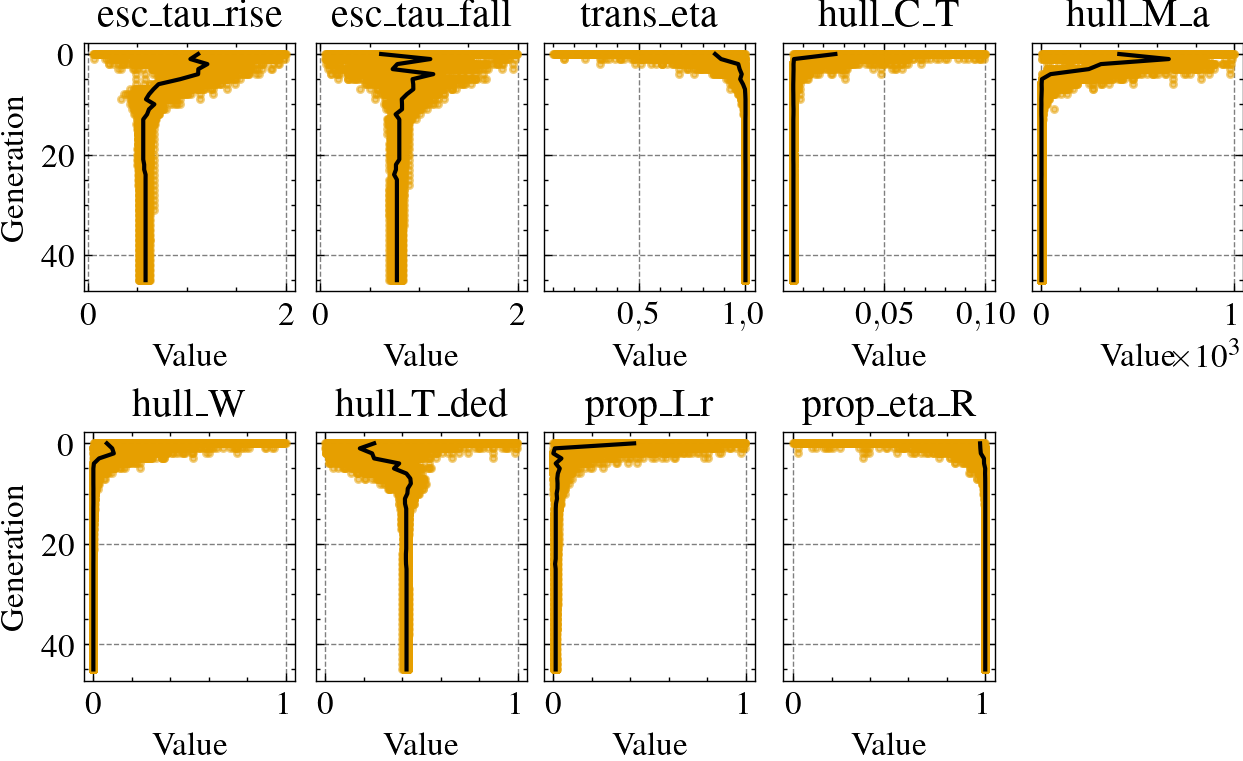

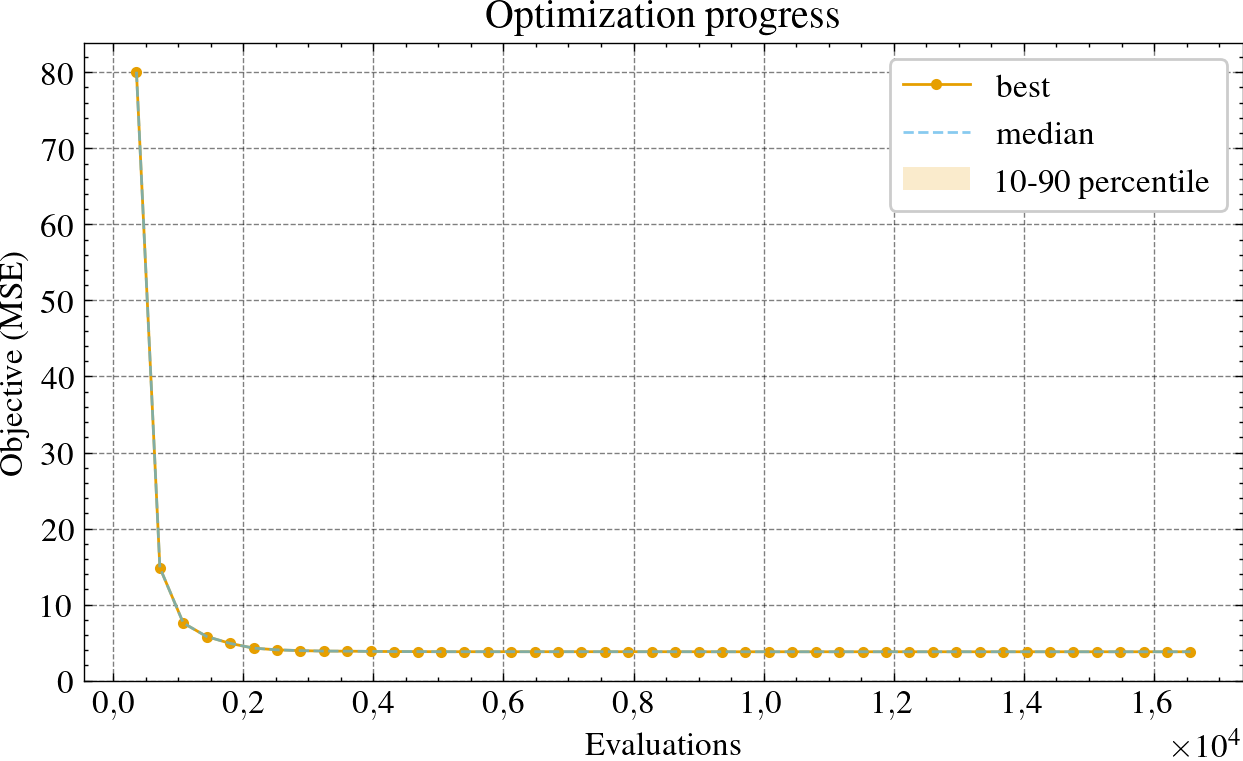

CPU times: user 5.27 s, sys: 2.69 s, total: 7.96 s
Wall time: 1min 28s


In [50]:
%%time
## PROPULSION OPTIMIZATION

# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'pilot_d']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][130:] # This reduced section also works well

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
params_bounds, _ = build_params_bounds()

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

try:
    # Initialize the problem
    model = Propulsion
    model_params = propulsion_params
    constraint_funcs = make_constraints(model, model_params, params_bounds)
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=RobustScaler,
        # data_scaler=StandardScaler,
        elementwise_runner=runner,
        constraint_funcs=constraint_funcs,
        # print_exceptions=True,
    )

    algorithm = DE(
        # pop_size=100*len(params_bounds),
        pop_size=40*len(params_bounds),
        sampling=LHS(),
        # variant="DE/rand/1/bin",
        variant="DE/best/1/bin",
        F=0.5,
        CR=0.9,
        dither='vector',
    )

    # Specify termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        # period=100,
        n_max_gen=1000,
        n_max_evals=1000000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# for col in data_cols:
#     plot_compare(df_train, best_fit_data, col)


In [58]:
params_bounds

{'esc_tau_rise': {'min': 0.05, 'max': 2},
 'esc_tau_fall': {'min': 0.05, 'max': 2},
 'trans_eta': {'min': 0.1, 'max': 1.0},
 'hull_C_T': {'min': 0.005, 'max': 0.1},
 'hull_M_a': {'min': 0.0, 'max': 1000},
 'hull_W': {'min': 0.0, 'max': 1.0},
 'hull_T_ded': {'min': 0.0, 'max': 1.0},
 'prop_I_r': {'min': 1e-06, 'max': 1.0},
 'prop_eta_R': {'min': 0.0, 'max': 1.0}}

In [59]:
best_params

{'esc_tau_rise': 0.5816684334159131,
 'esc_tau_fall': 0.7773312171657636,
 'trans_eta': 0.9997760700277531,
 'hull_C_T': 0.005177747137345918,
 'hull_M_a': 0.4829952099991946,
 'hull_W': 3.492751159781993e-07,
 'hull_T_ded': 0.4227126423696422,
 'prop_I_r': 0.012356862014850173,
 'prop_eta_R': 0.9999444579804533}

In [60]:
propulsion_params | best_params

{'motor_R_A': 0.019579524515654242,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_I_r': 0.011828773027862982,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_F_s': 12550,
 'esc_V_ds_ov': 2.0,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_E_on': 7e-05,
 'esc_E_off': 0.00011,
 'esc_V_F': 3.338359854985,
 'esc_r_D': 0.004027165799996619,
 'esc_Q_rr': 1.9e-07,
 'esc_tau_fall': 0.7773312171657636,
 'esc_tau_rise': 0.5816684334159131,
 'trans_eta': 0.9997760700277531,
 'trans_I_r_in': 0,
 'trans_I_r_out': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': array([ 0.37208208, -0.10825004, -0.16735476,  0.02821403]),
 'prop_k_Q_coeffs': array([ 0.05470368, -0.01753569, -0.00050999, -0.01078306]),
 'prop_eta_R': 0.9999444579804533,
 'prop_I_r': 0.012356862014850173,
 'hull_C_T': 0.005177747137345918,
 'hull_M': 293.7,
 'hull_M_a': 0.4829952099991946,
 'hull_S_water': 4.1429

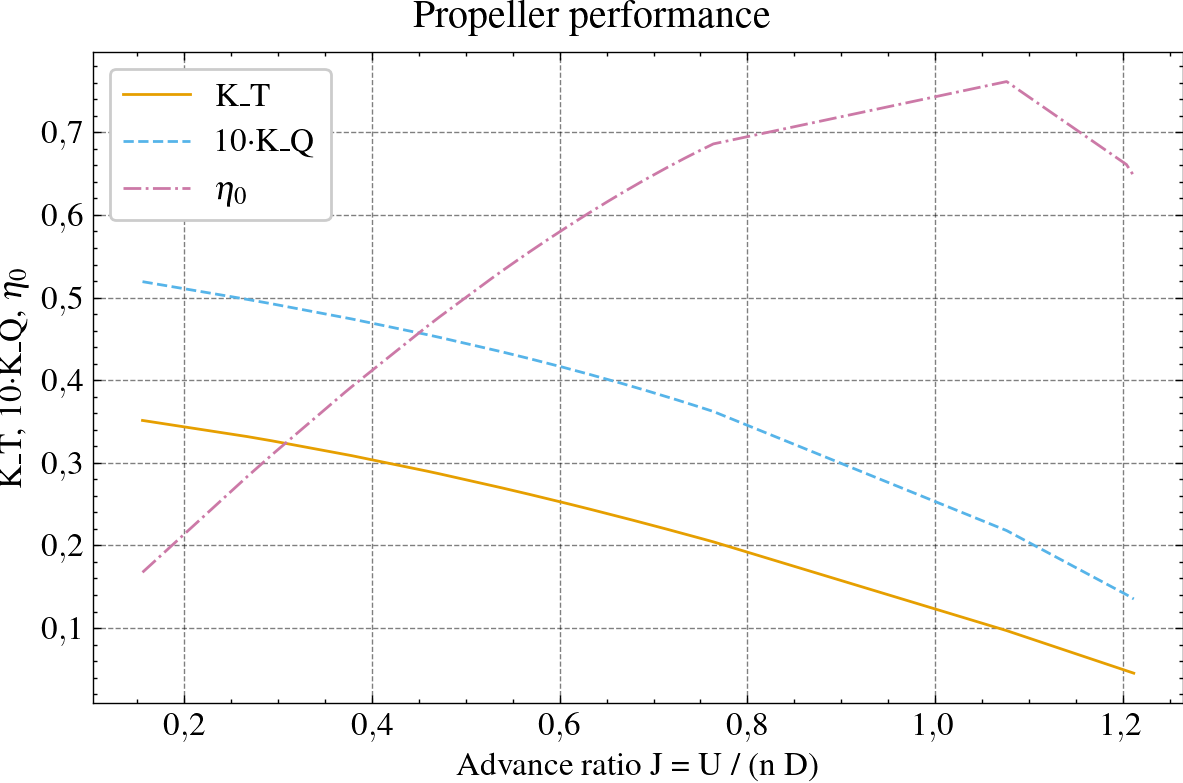

In [61]:
# Check Propeller curve
def filter_prop_p_outints(df, params):
    df = df.copy()

    prop_D     = params["prop_D"]
    rho_water  = params["rho_water"]
    hull_W  = params["hull_W"]
    trans_k = params['trans_k']

    # Kinematics
    prop_w = df["motor_w"] * trans_k
    df["prop_n"] = prop_w / (2*np.pi)                       # [rev/s]
    df["u_rel"]  = (1.0 - hull_W) * df["hull_u"]               # inflow at prop
    df["J"]      = df["u_rel"] / (df["prop_n"] * prop_D)

    # Basic operating filters
    m = (
        (df["prop_n"].abs() > 1)      # ~>12 rpm
        & (df["u_rel"] > 0.1)           # avoid U≈0
        & (df["prop_t"] > 1.0)          # avoid almost-zero thrust
        & (df["prop_q"] > 0.05)         # positive, non-trivial torque
        & (df["J"] > 0)
        & np.isfinite(df["J"])
    )
    df = df[m].copy()

    # Dimensionless coefficients
    df["K_T"] = df["prop_t"] / (rho_water * df["prop_n"]**2 * prop_D**4)
    df["K_Q"] = df["prop_q"] / (rho_water * df["prop_n"]**2 * prop_D**5)

    # Efficiency
    df["eta0"] = df["J"] * df["K_T"] / (2*np.pi * df["K_Q"])

    # Filter absurd efficiencies and J outliers
    m_eta = (
        (df["eta0"] > 0.0) & (df["eta0"] < 1) &
        (df["J"] < 1.5)
    )
    df = df[m_eta].copy()
    return df

df_prop = filter_prop_p_outints(best_fit_data, model_params | best_params).sort_values("J")

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(df_prop["J"], df_prop["K_T"], label="K_T")
ax1.plot(df_prop["J"], 10.0 * df_prop["K_Q"], label="10·K_Q")
ax1.plot(df_prop["J"], df_prop["eta0"], label=r'$\eta_0$')
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r'K_T, 10·K_Q, $\eta_0$')
ax1.grid(True)

ax1.legend(loc="best")
plt.suptitle('Propeller performance')
plt.show()


In [62]:
test_section = test_sections[0]

df_test = df.loc[(df.index >= test_section['start']) & (df.index <= test_section['end']), ['t'] + data_cols + input_cols]

T = df_test['t'].to_numpy()
U = df_test[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

df_pred = model_function(T, U, X0, **(model_params | best_params))
display(df_pred[['esc_i_in', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']].describe().T[['mean', 'min', 'max']])
# df_pred[['esc_i_in', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']].describe().T[['mean', 'min', 'max']].T.to_dict()

mean      min         max
esc_i_in   32.854396 -5.51638  167.691569
prop_J      0.801802  0.00000    1.500000
prop_k_q    0.033529  0.00000    0.054704
prop_k_T    0.192083  0.00000    0.372082
prop_q      7.538452  0.00000   26.987701
prop_t    186.729343  0.00000  737.082692
hull_u      2.894713  0.00000    5.596244
hull_r    186.593979  0.00000  595.921685

MSE        MAE       RMSE            AE        R2
section data                                                               
D       motor_w    259.202530   8.043228  16.099768 -39359.978510  0.948753
        esc_i_in    32.799834   3.098223   5.727114   1649.360972  0.945696
        hull_u       0.194133   0.286459   0.440606  -1572.451596  0.869978
E       motor_w   1244.017659  12.169296  35.270635  -6542.989959  0.839326
        esc_i_in   512.057090   5.680093  22.628678  -1196.326834 -0.037894
        hull_u       0.337639   0.271970   0.581067    -89.852632  0.875346
F1      motor_w    492.674712  14.245124  22.196277  -2434.162808  0.940345
        esc_i_in    19.086696   2.451236   4.368832   -284.979951  0.991361
        hull_u       0.479897   0.412621   0.692746    -76.526396  0.810025
F2      motor_w    323.488431  10.936193  17.985784  -3683.096154  0.956658
        esc_i_in    68.163167   3.719505   8.256099    201.686661  0.955790
        hull_u       0.397686   0.449100   0.630624   -123.862646  0.828619

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_d.pdf


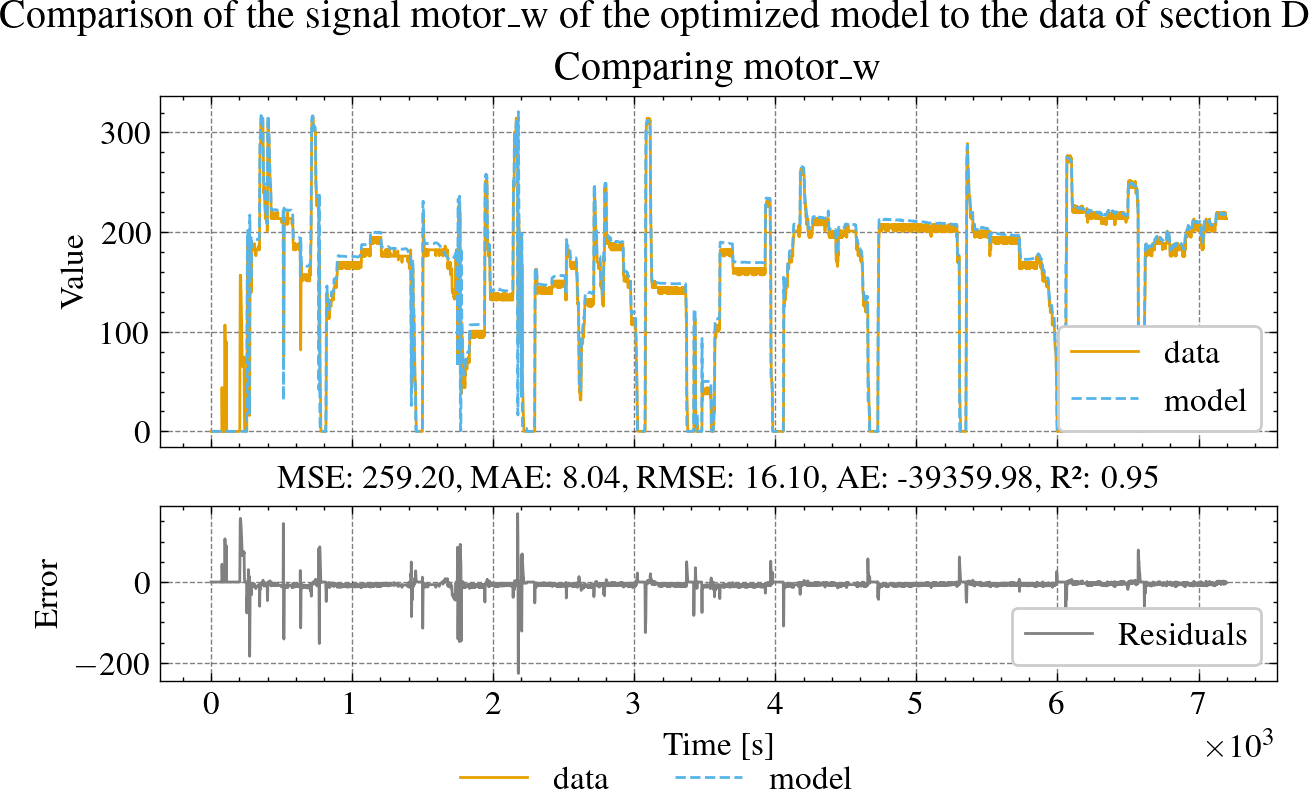

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_d.pdf


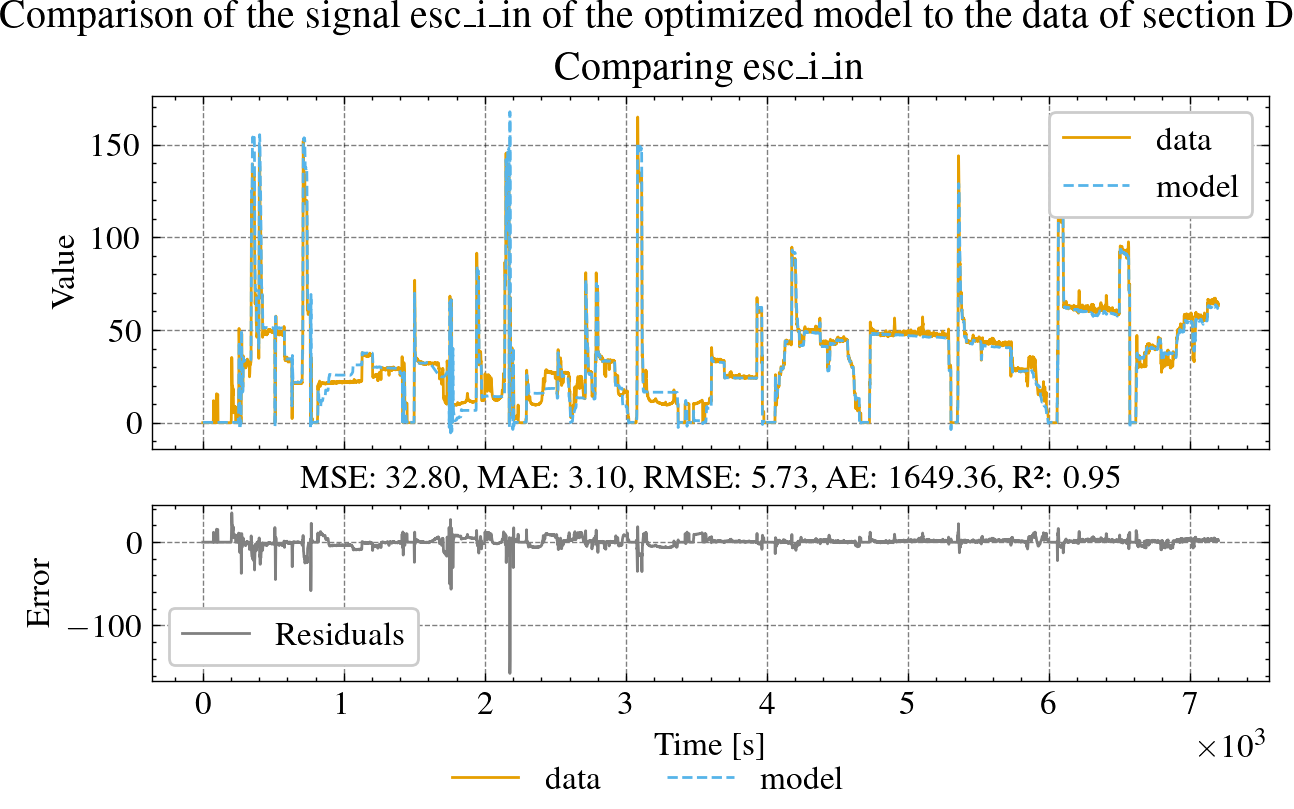

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_d.pdf


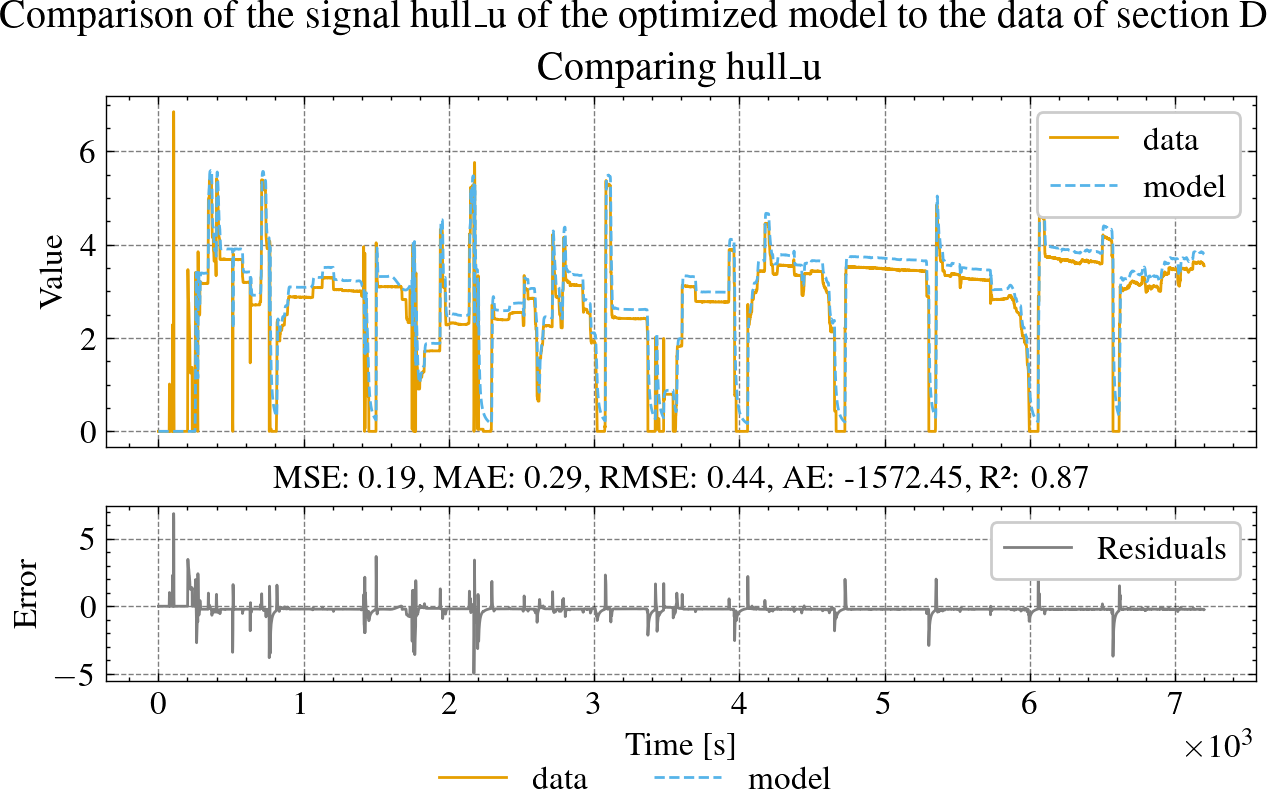

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_e.pdf


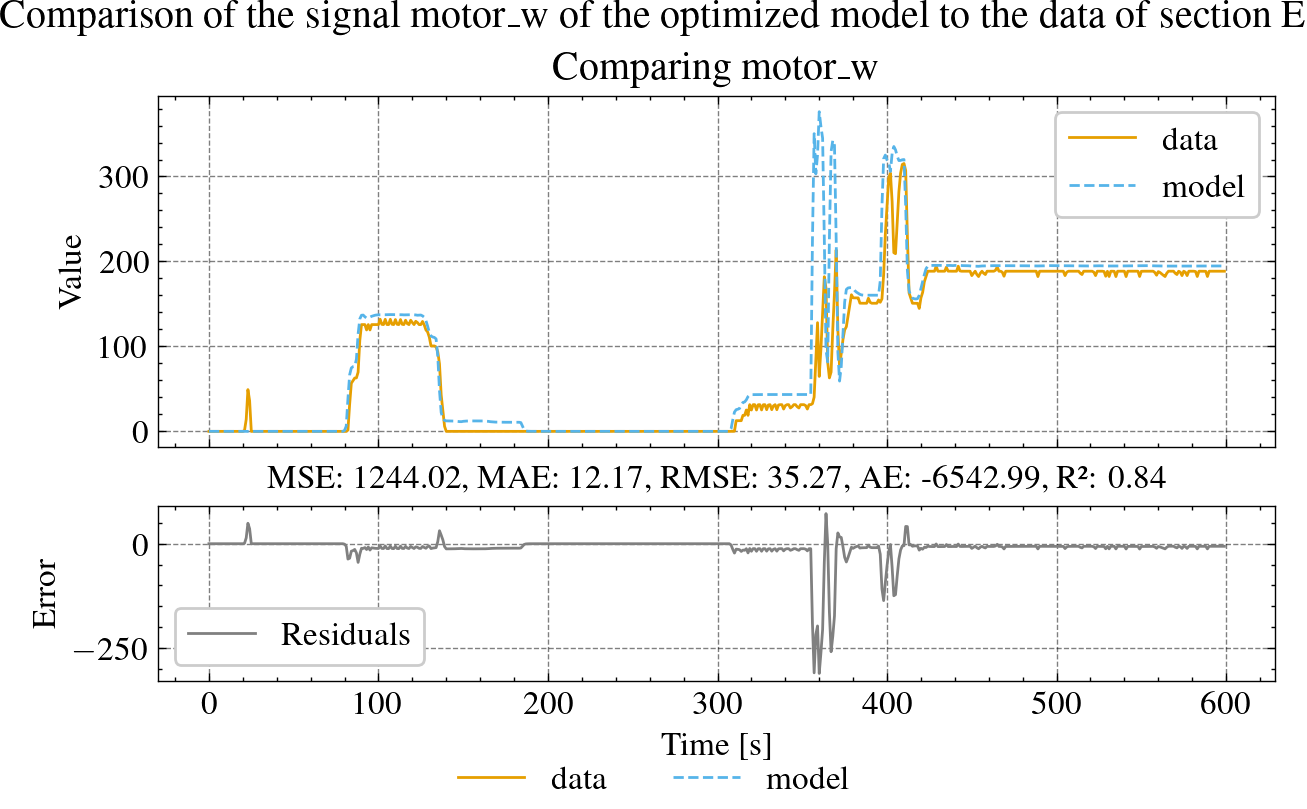

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_e.pdf


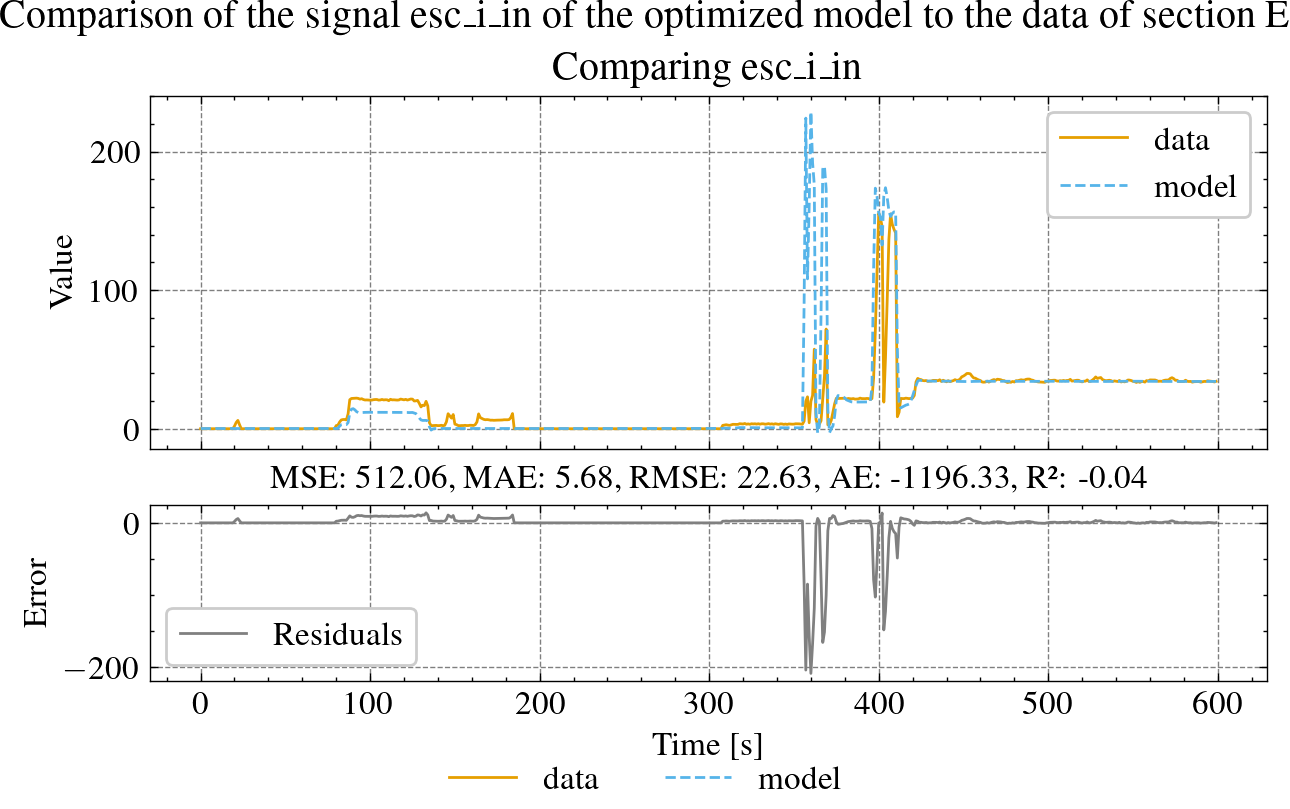

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_e.pdf


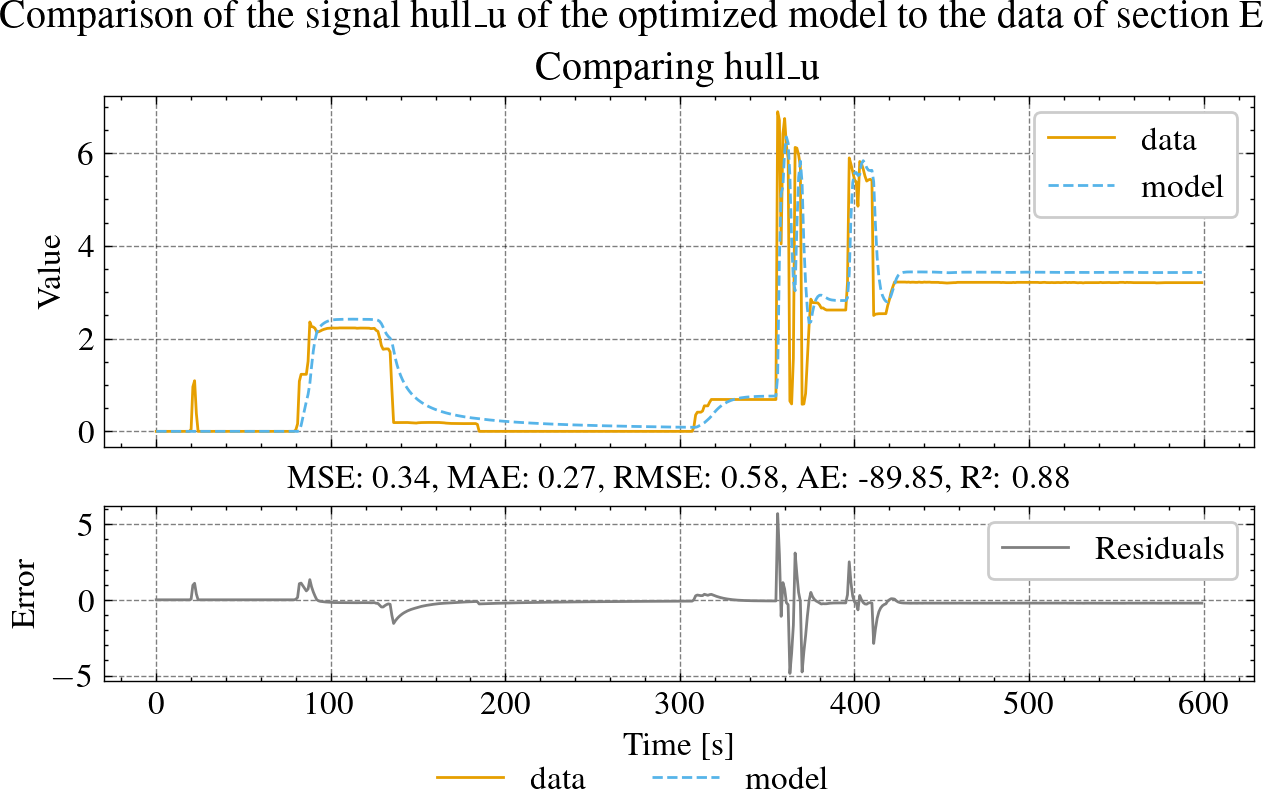

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f1.pdf


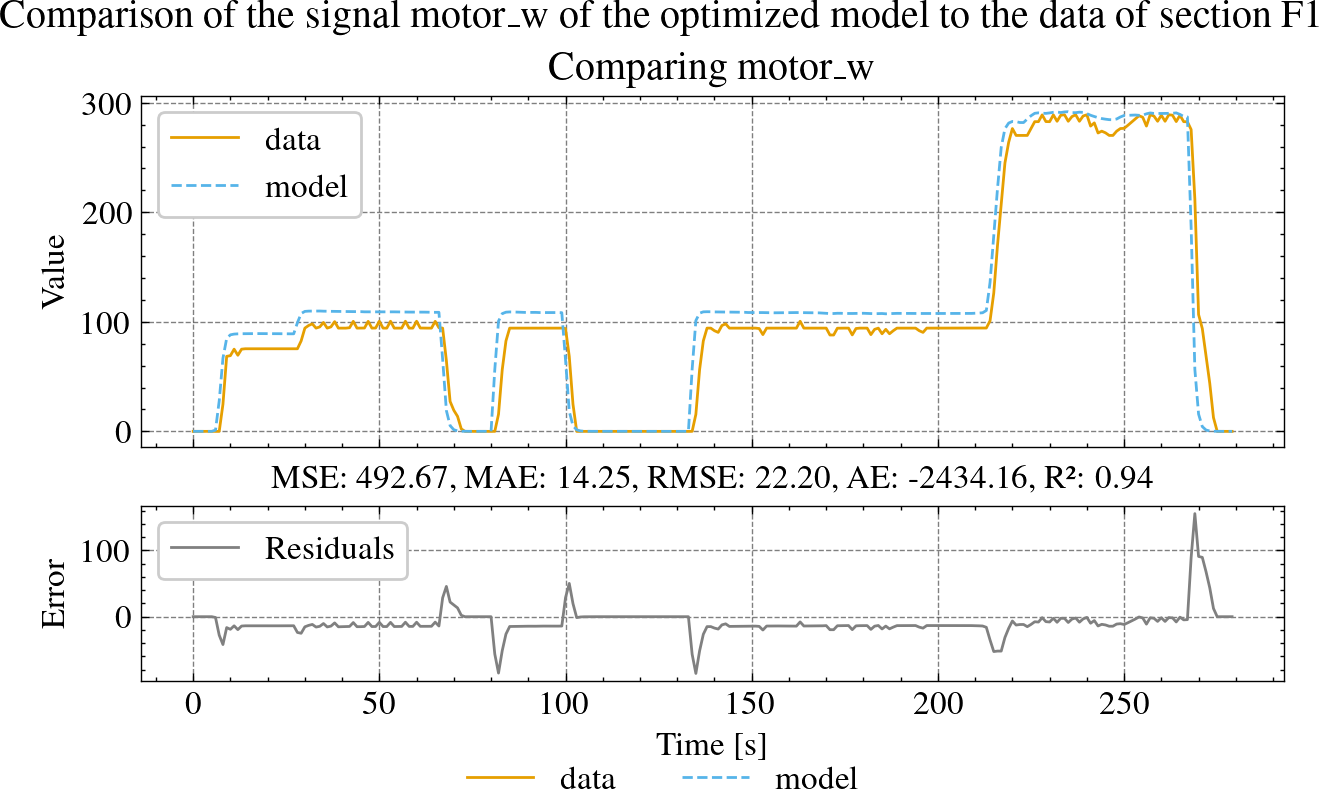

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f1.pdf


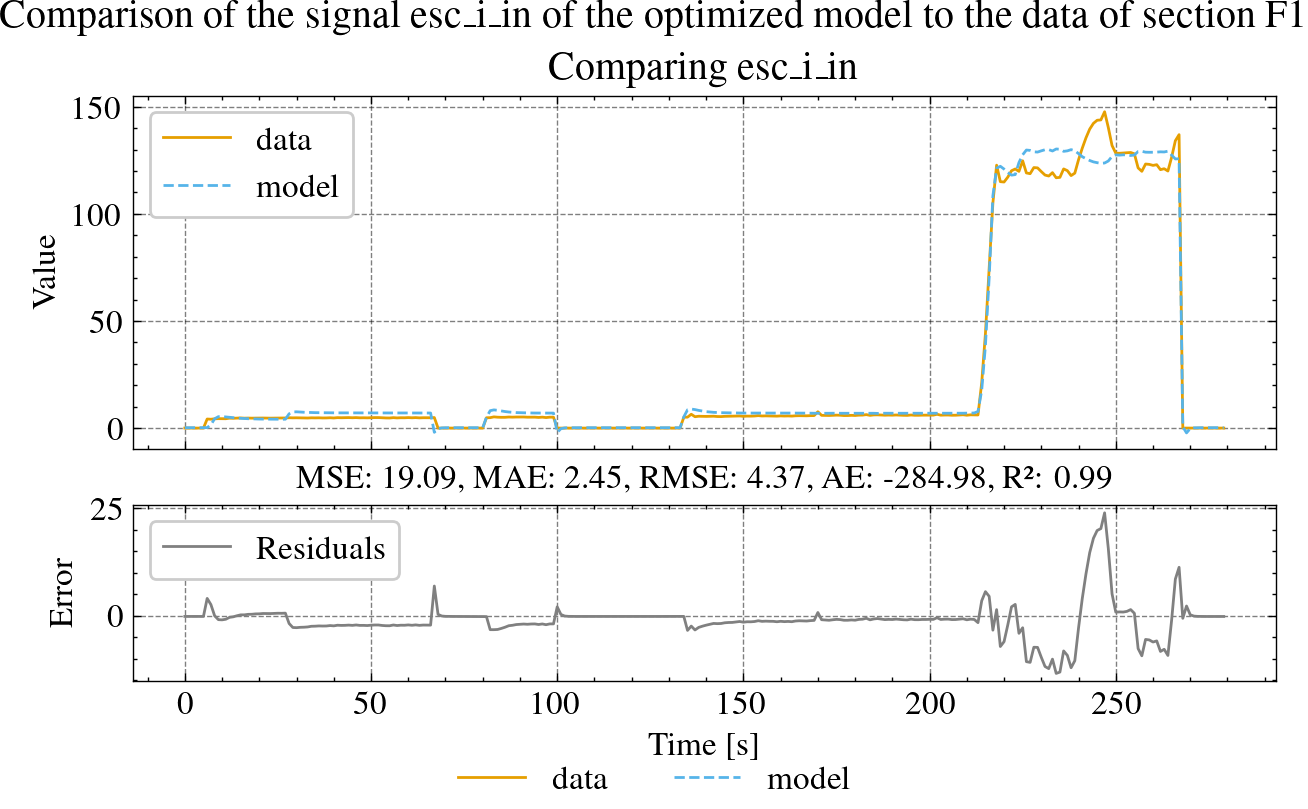

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f1.pdf


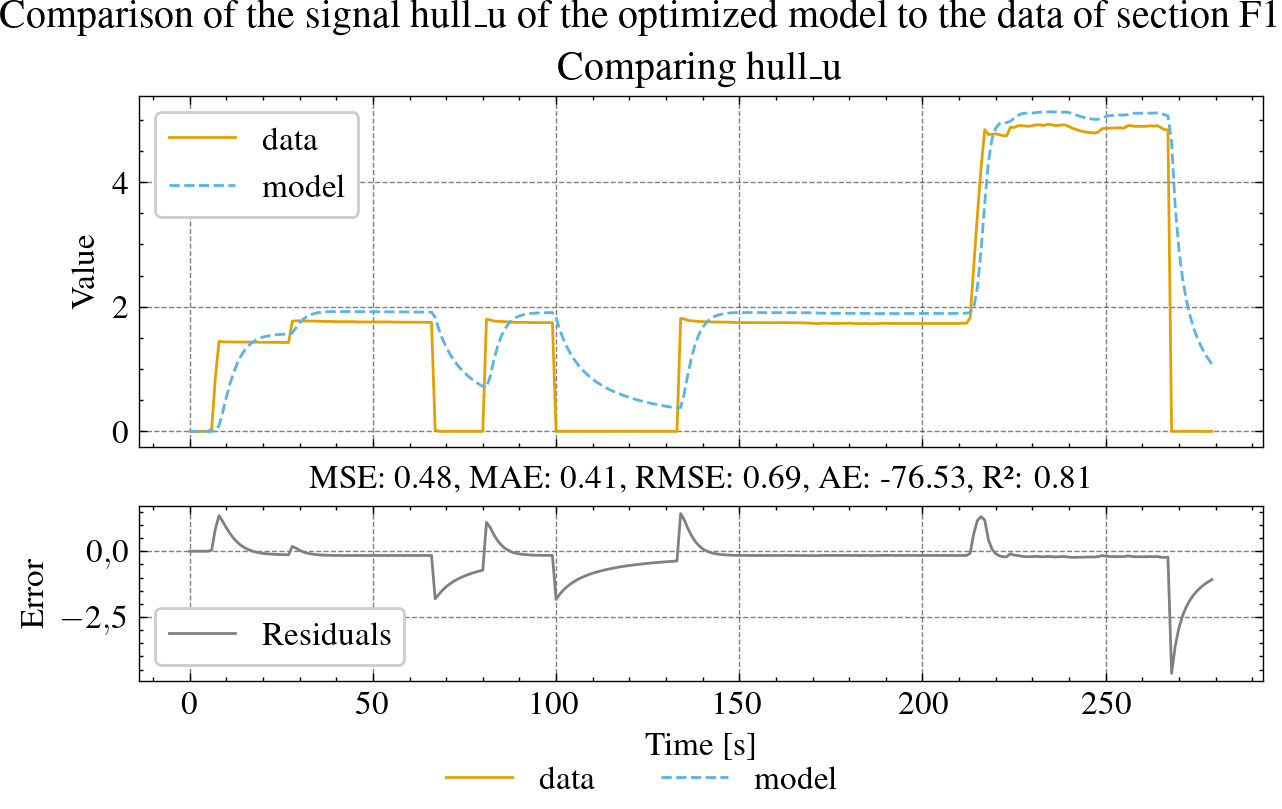

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f2.pdf


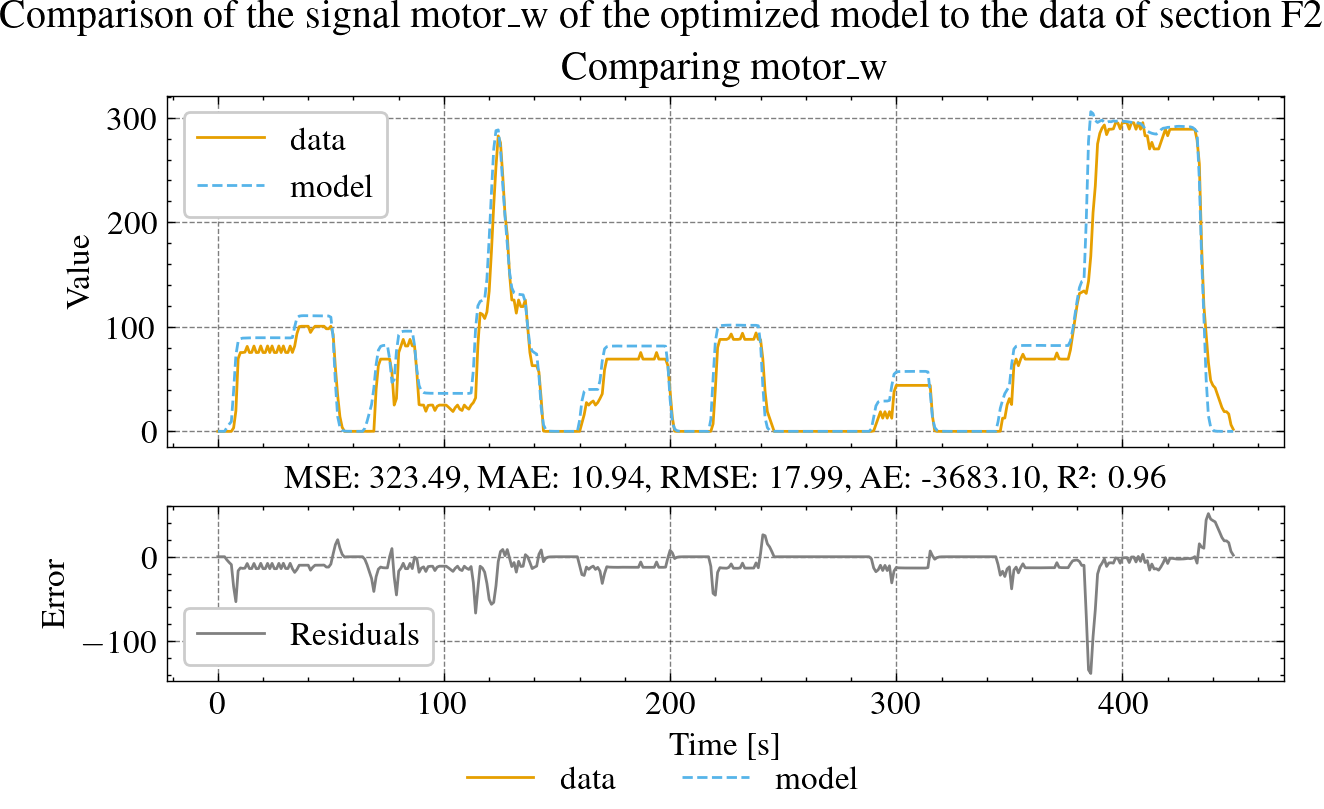

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f2.pdf


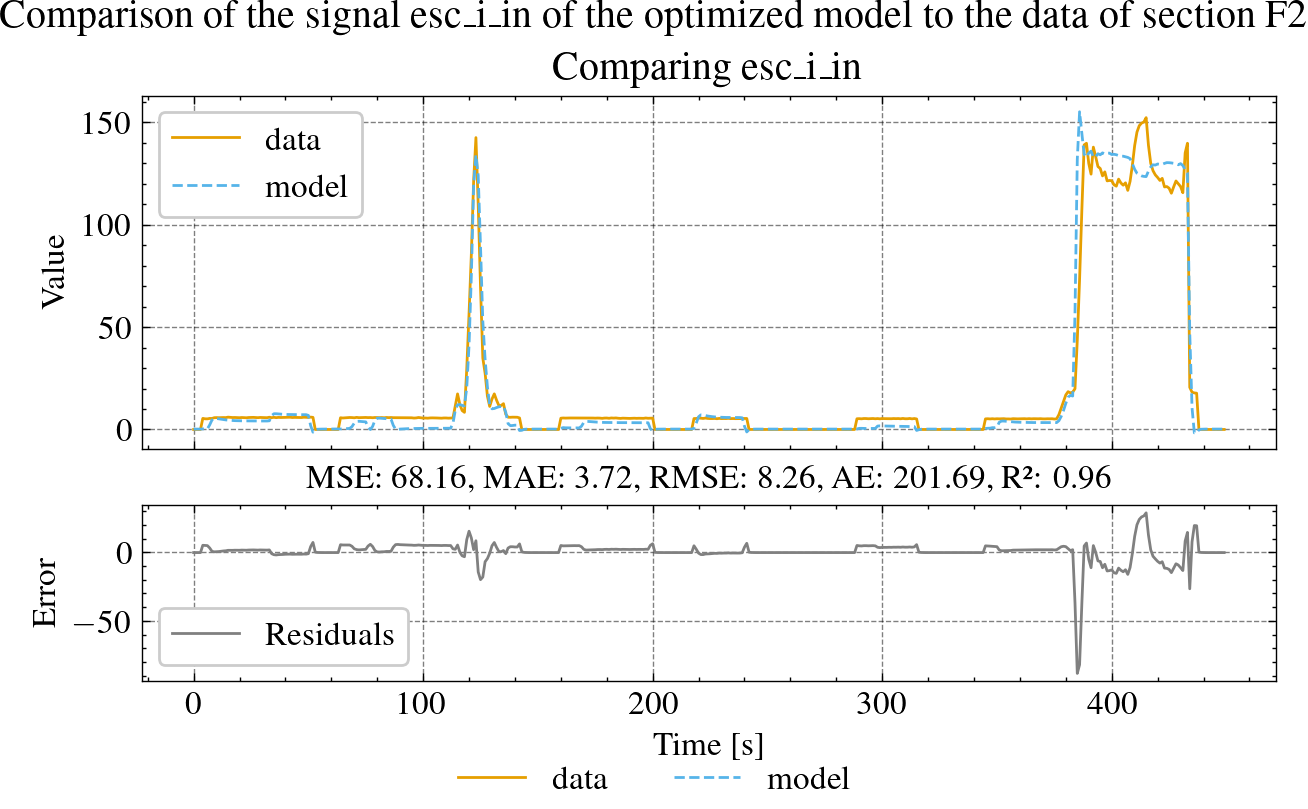

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f2.pdf


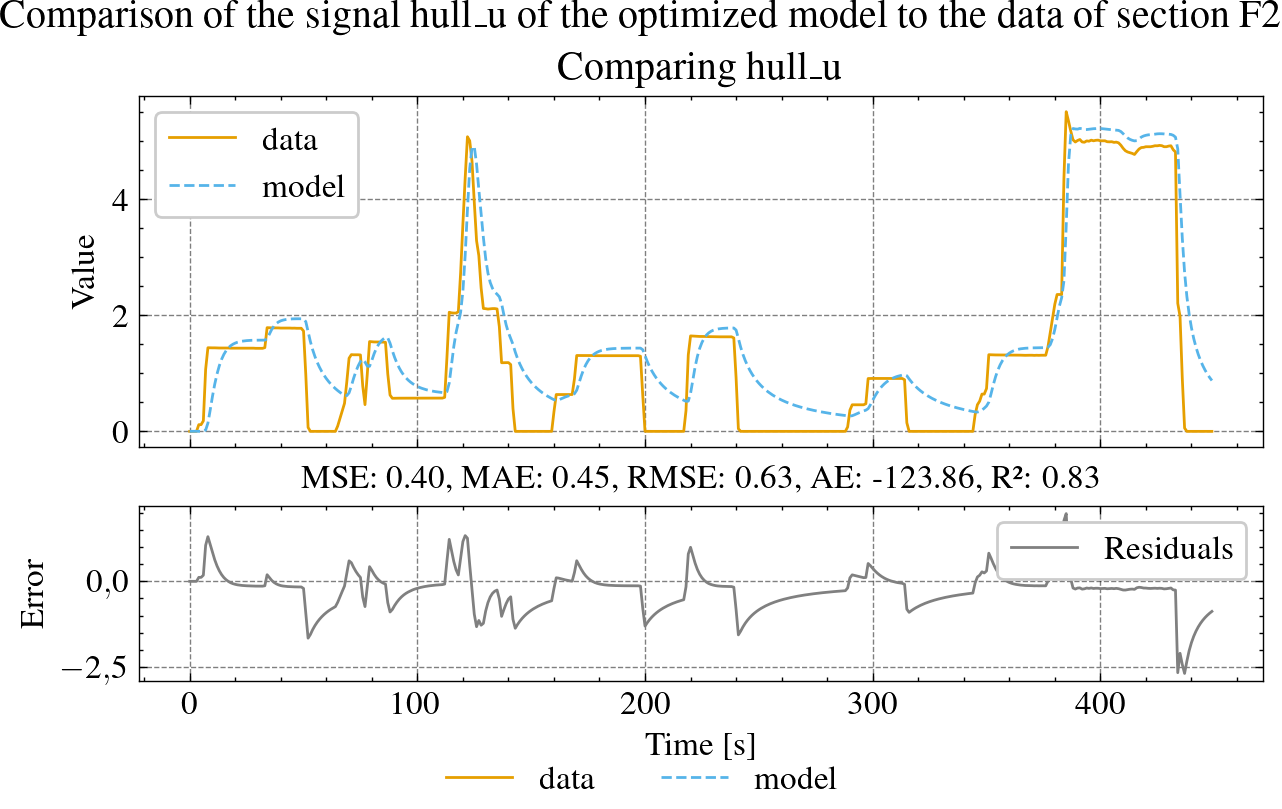

In [63]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(propulsion_params | best_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:propulsion_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/propulsion_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(propulsion_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/propulsion_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [65]:
# # Plot the original data and the fitted curve
# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_params.pdf',
#     show_title='propulsion optimum parameters evolution at each propulsion',
#     save_title='Evolução dos parâmetros ótimos do modelo da Propulsão à cada geração',
#     ncol=2,
#     fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, max_columns=4, show=False)
# )

# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_error.pdf',
#     show_title='propulsion optimization error evolution',
#     save_title='Evolução do erro de otimização do modelo da Propulsão',
#     ncol=2,
#     fig=plot_optimization_error(result, show=False),
# )

# for col in data_cols:
#     fig_save_and_show(
#         filename=f'{latex_img_path}/propulsion_optimization_residuals_{col}_train.pdf',
#         show_title=f'Comparison of the signal {col} of the optized model to the train data',
#         save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
#         ncol=2,
#         fig=plot_compare(df_train, best_fit_data, col, show=False),
#     )

In [84]:
propulsion_params | best_params

{'motor_R_A': 0.019579524515654242,
 'motor_B': 0.0012793008044770459,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_I_r': 0.011828773027862982,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_F_s': 12550,
 'esc_V_ds_ov': 2.0,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_E_on': 7e-05,
 'esc_E_off': 0.00011,
 'esc_V_F': 3.338359854985,
 'esc_r_D': 0.004027165799996619,
 'esc_Q_rr': 1.9e-07,
 'esc_tau_fall': 0.7773312171657636,
 'esc_tau_rise': 0.5816684334159131,
 'trans_eta': 0.9997760700277531,
 'trans_I_r_in': 0,
 'trans_I_r_out': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': array([ 0.37208208, -0.10825004, -0.16735476,  0.02821403]),
 'prop_k_Q_coeffs': array([ 0.05470368, -0.01753569, -0.00050999, -0.01078306]),
 'prop_eta_R': 0.9999444579804533,
 'prop_I_r': 0.012356862014850173,
 'hull_C_T': 0.005177747137345918,
 'hull_M': 293.7,
 'hull_M_a': 0.4829952099991946,
 'hull_S_water': 4.1429

In [67]:
metrics_list1 = metrics_list
best_params_1 = best_params

#### Comparison Of Methods

In [68]:
# # Plot the original data and the fitted curve
# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_params_opt_all.pdf',
#     show_title='propulsion optimum parameters evolution at each propulsion',
#     save_title='Evolução dos parâmetros ótimos do modelo da Propulsão à cada geração',
#     ncol=2,
#     fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, show=False)
# )

# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_error_opt_all.pdf',
#     show_title='propulsion optimization error evolution',
#     save_title='Evolução do erro de otimização do modelo da Propulsão',
#     ncol=2,
#     fig=plot_optimization_error(result, show=False),
# )

# for col in data_cols:
#     fig_save_and_show(
#         filename=f'{latex_img_path}/propulsion_optimization_residuals_{col}_train_opt_all.pdf',
#         show_title=f'Comparison of the signal {col} of the optized model to the train data',
#         save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
#         ncol=2,
#         fig=plot_compare(df_train, best_fit_data, col, show=False),
#     )

MSE        MAE       RMSE            AE        R2
section data                                                               
D       motor_w    259.202530   8.043228  16.099768 -39359.978510  0.948753
        esc_i_in    32.799834   3.098223   5.727114   1649.360972  0.945696
        hull_u       0.194133   0.286459   0.440606  -1572.451596  0.869978
E       motor_w   1244.017659  12.169296  35.270635  -6542.989959  0.839326
        esc_i_in   512.057090   5.680093  22.628678  -1196.326834 -0.037894
        hull_u       0.337639   0.271970   0.581067    -89.852632  0.875346
F1      motor_w    492.674712  14.245124  22.196277  -2434.162808  0.940345
        esc_i_in    19.086696   2.451236   4.368832   -284.979951  0.991361
        hull_u       0.479897   0.412621   0.692746    -76.526396  0.810025
F2      motor_w    323.488431  10.936193  17.985784  -3683.096154  0.956658
        esc_i_in    68.163167   3.719505   8.256099    201.686661  0.955790
        hull_u       0.397686   0.449100   0.630624   -123.862646  0.828619

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_d_opt_all.pdf


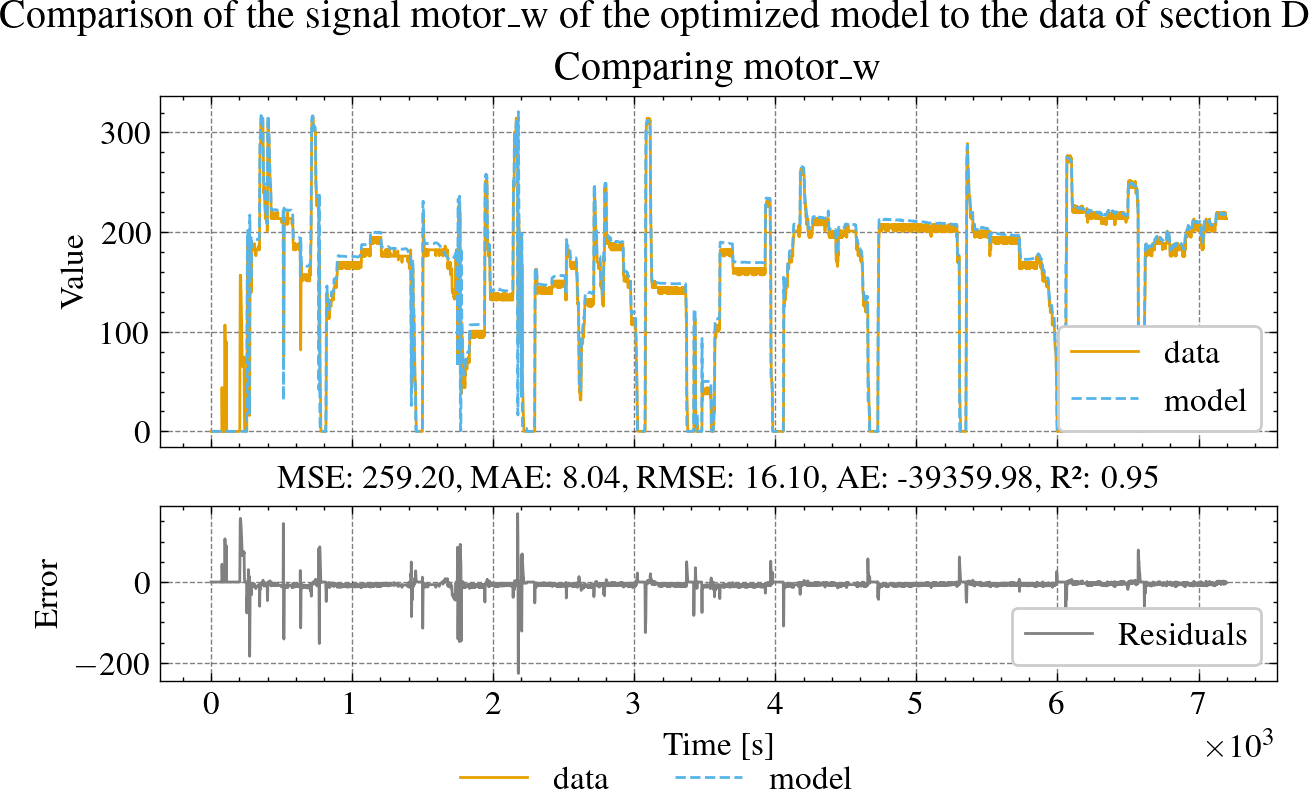

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_d_opt_all.pdf


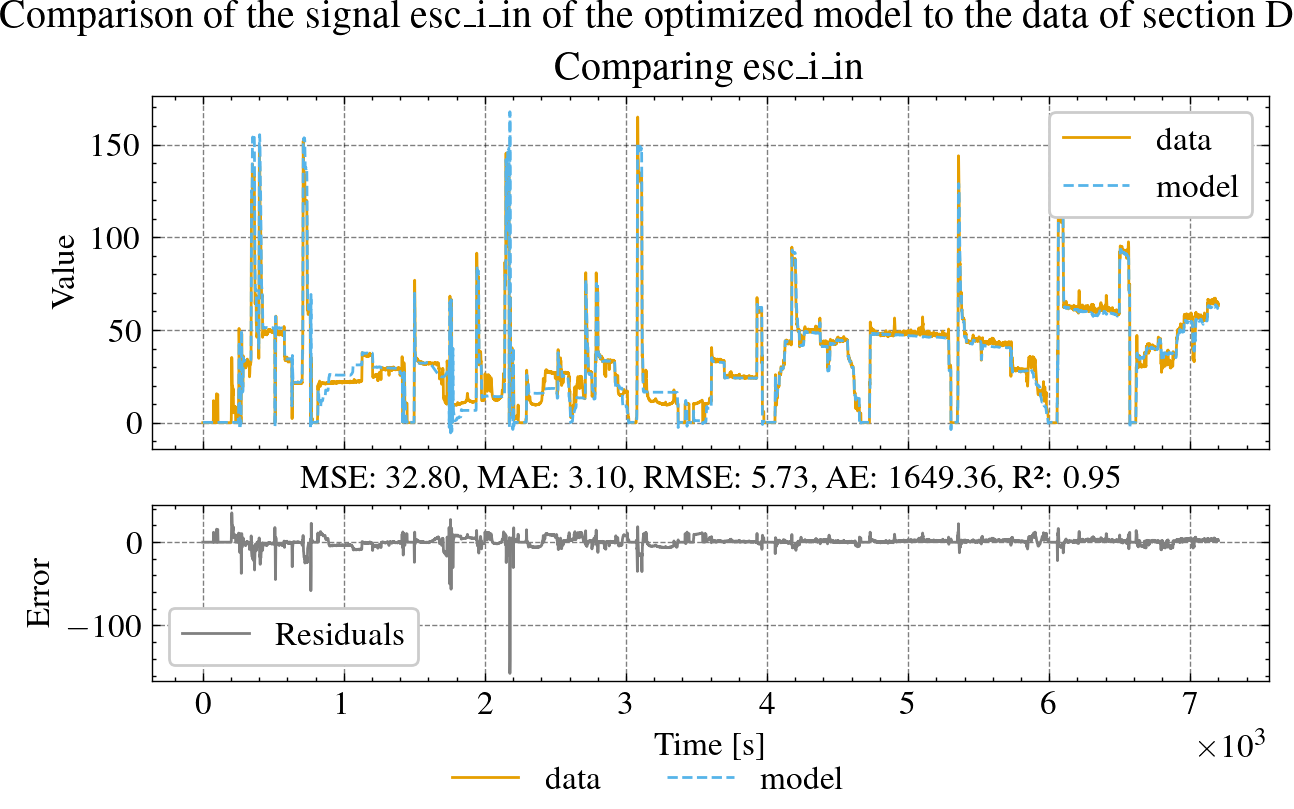

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_d_opt_all.pdf


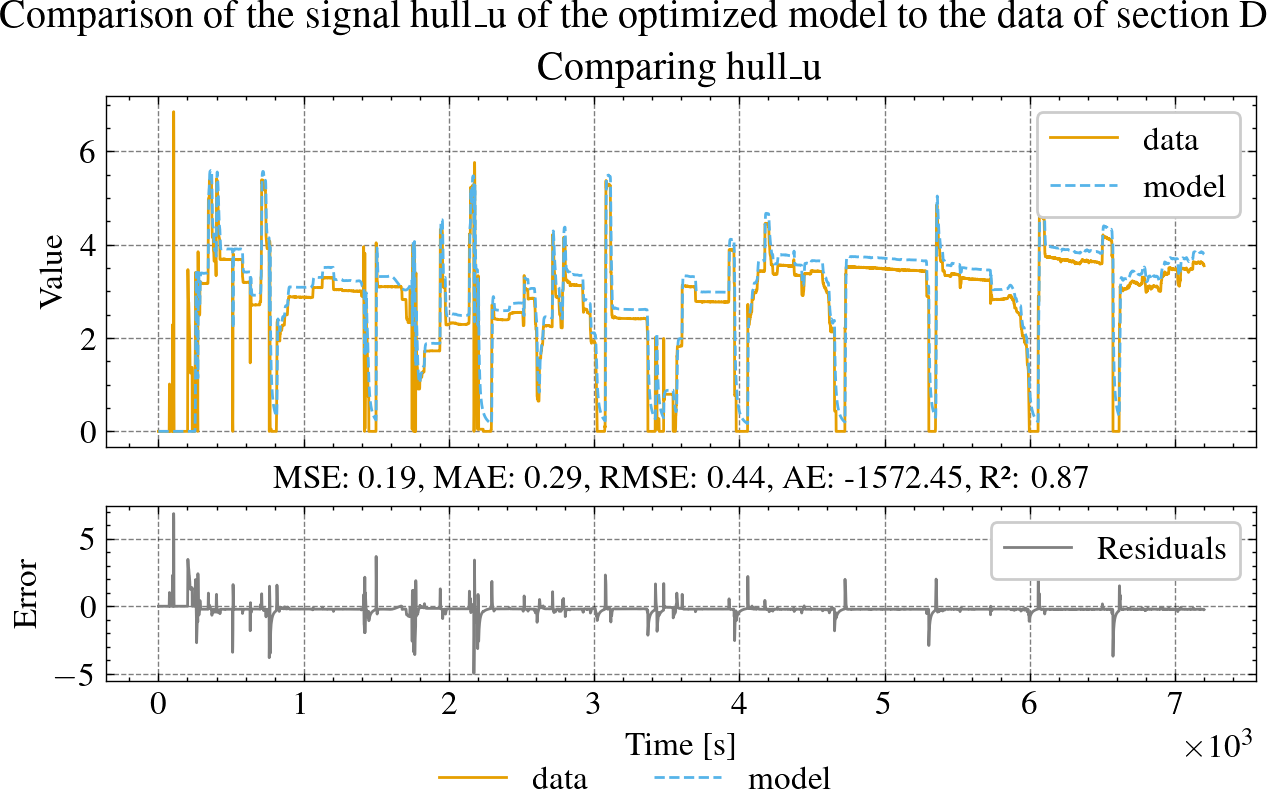

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_e_opt_all.pdf


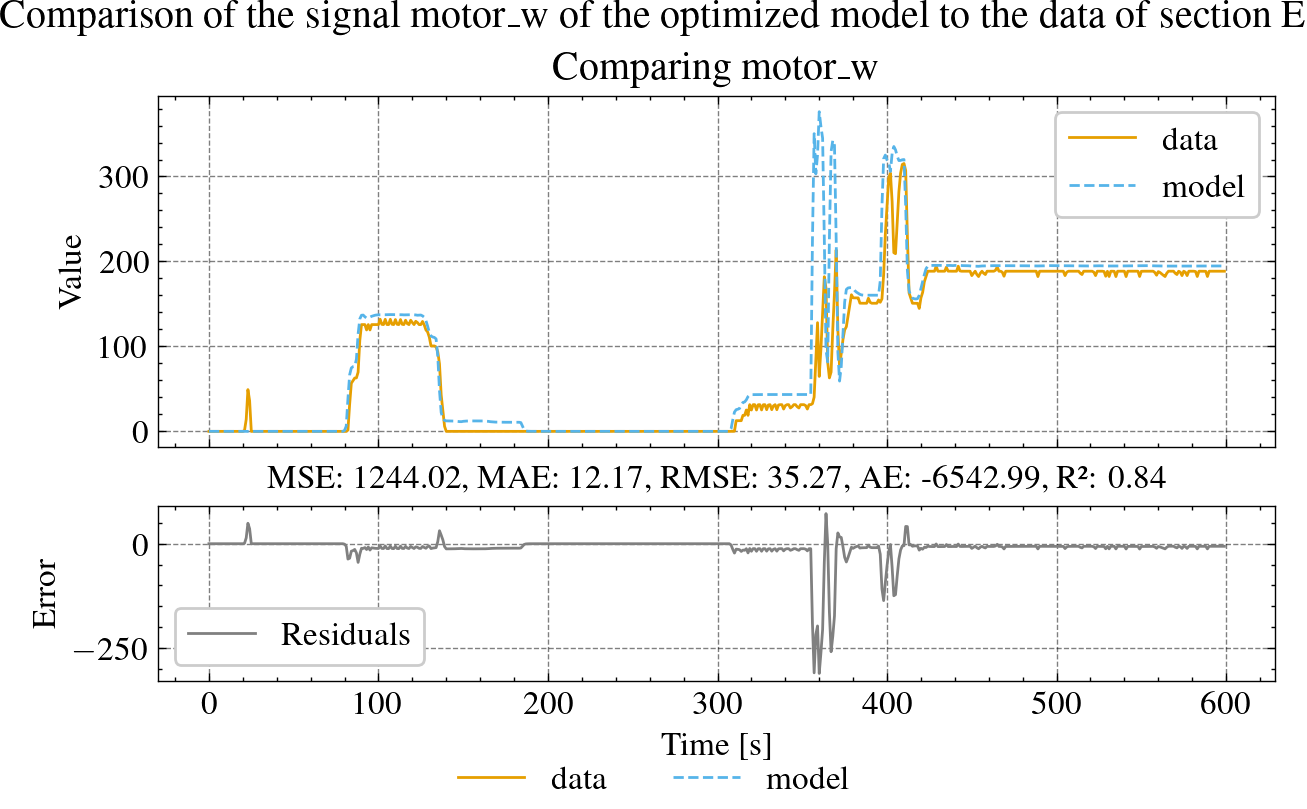

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_e_opt_all.pdf


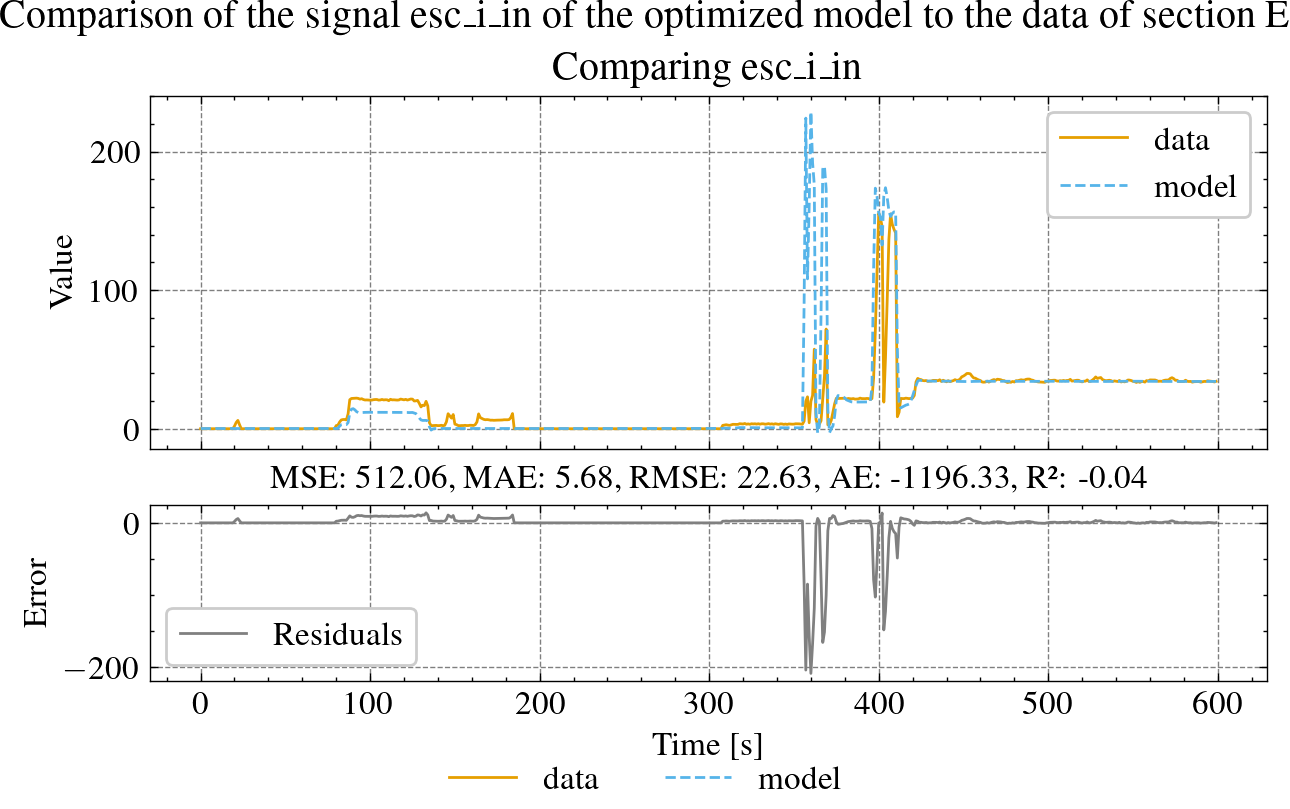

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_e_opt_all.pdf


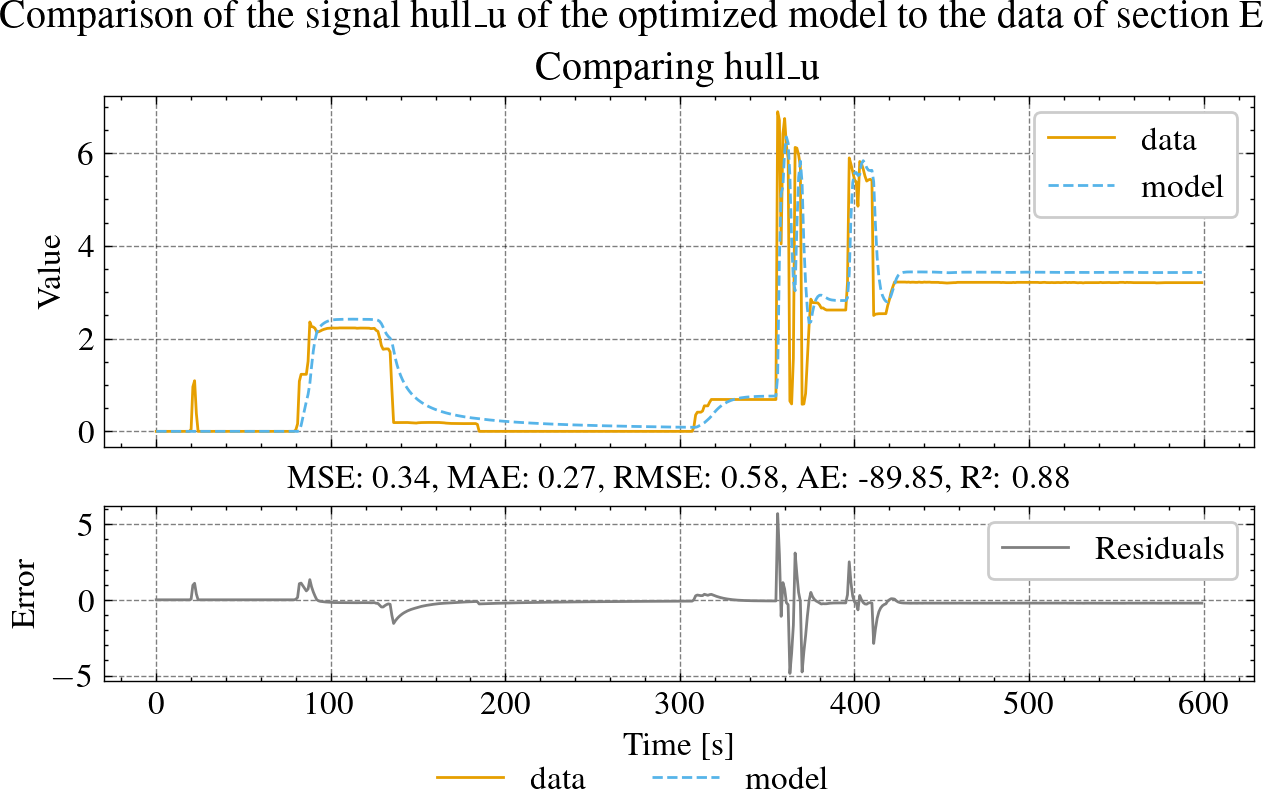

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f1_opt_all.pdf


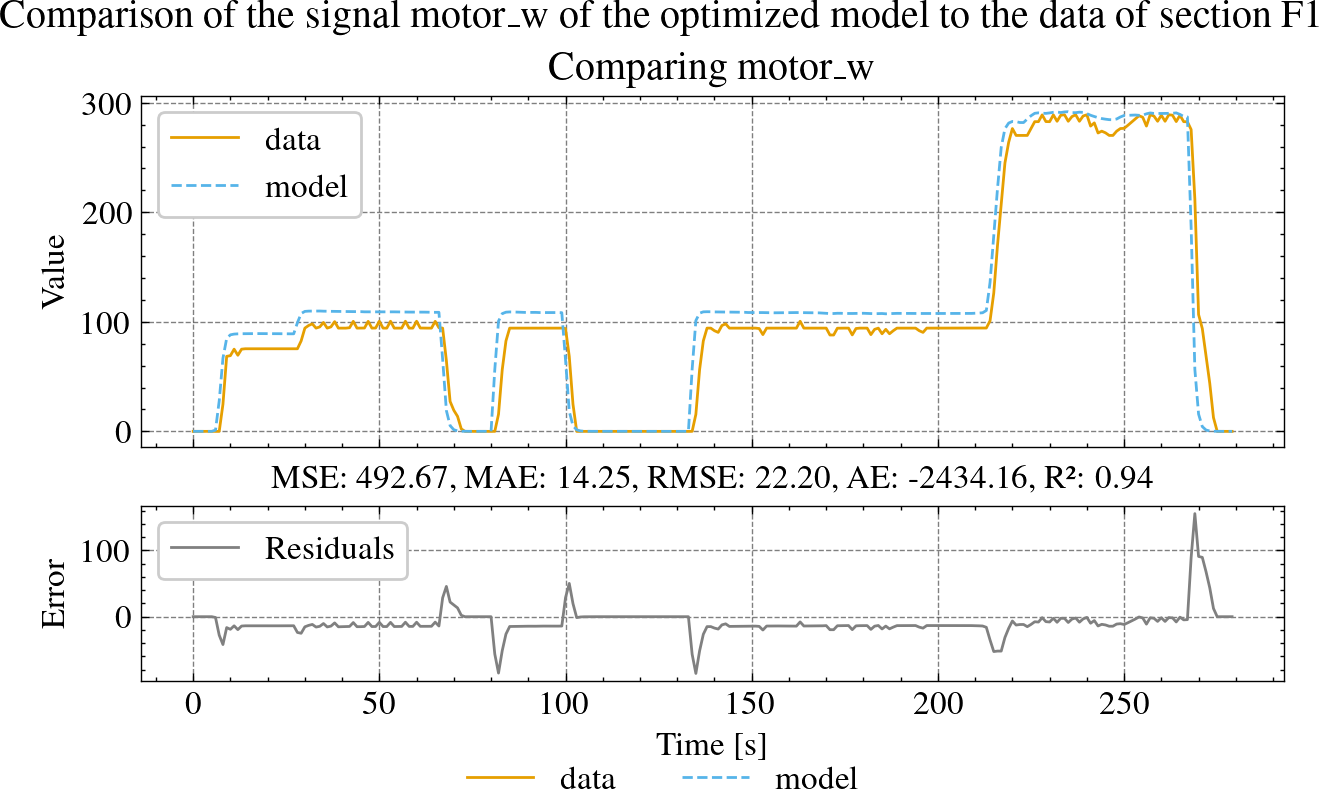

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f1_opt_all.pdf


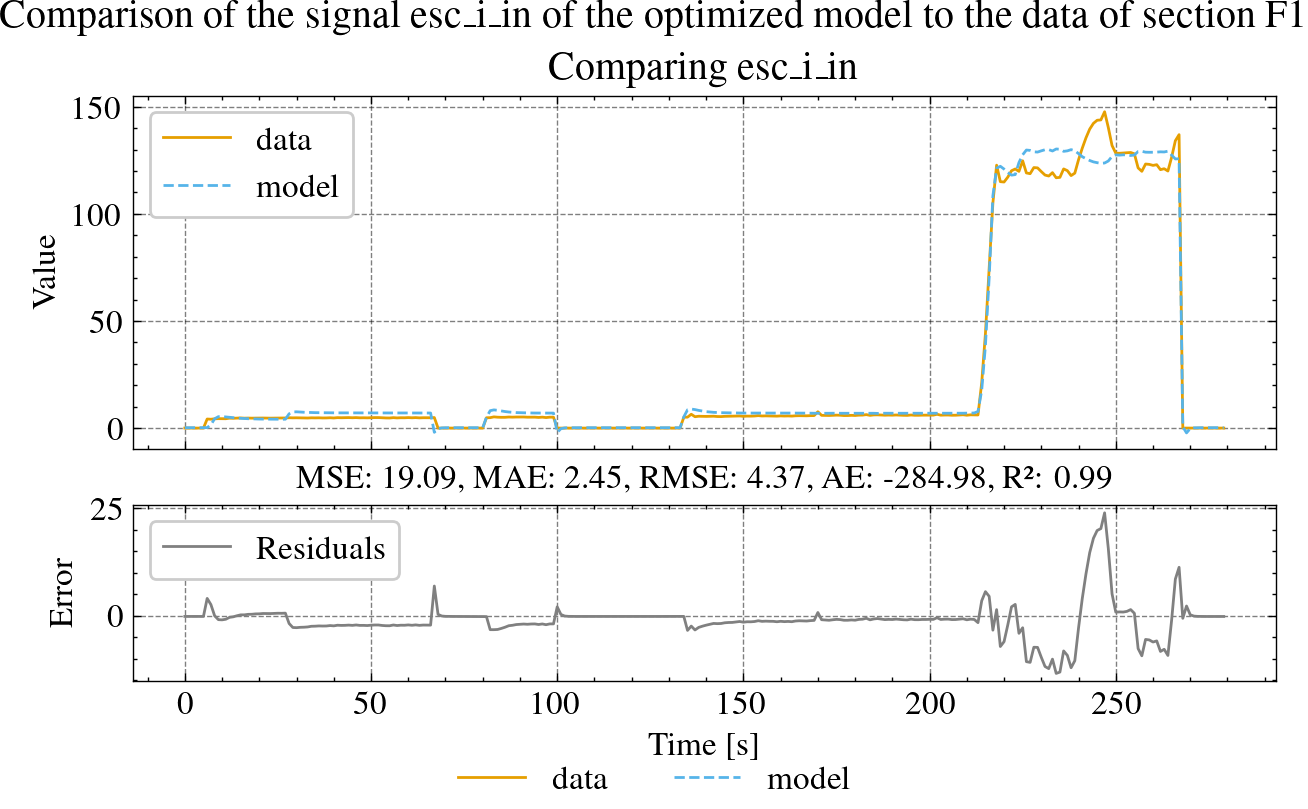

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f1_opt_all.pdf


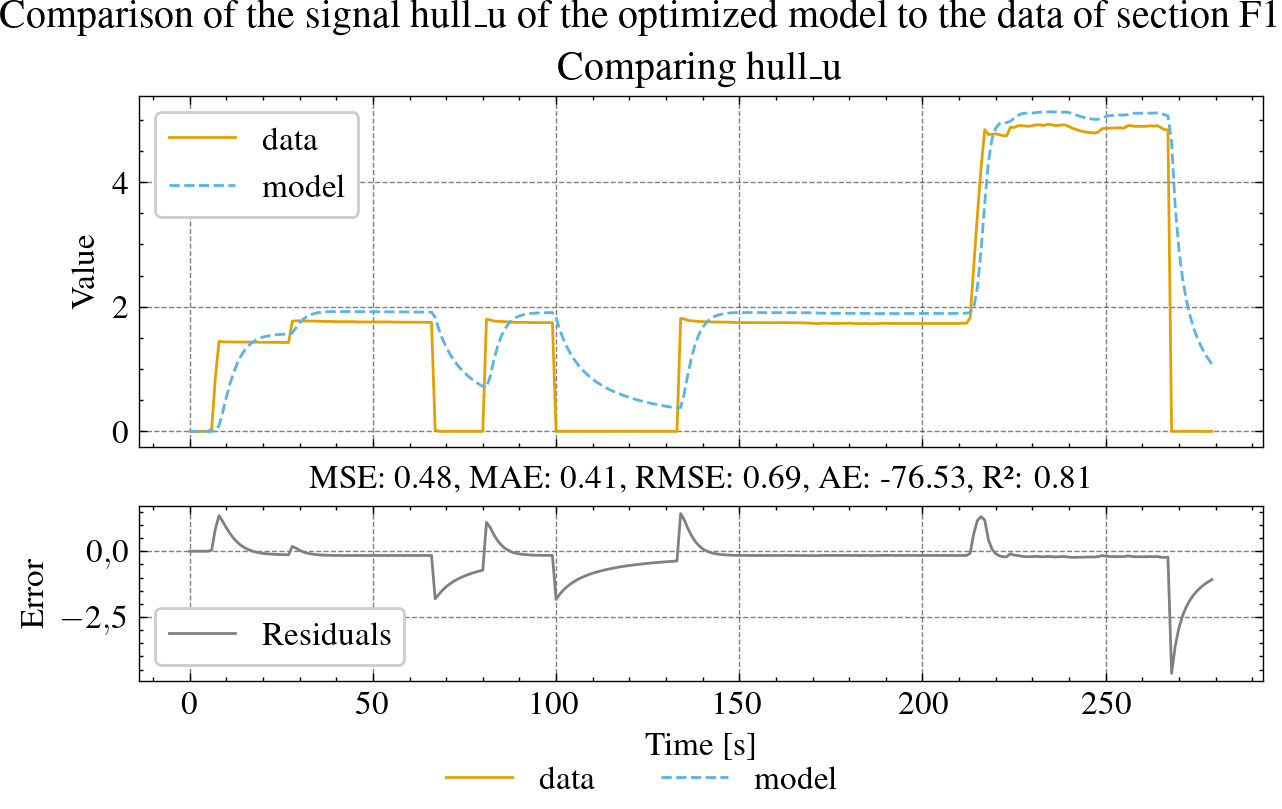

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f2_opt_all.pdf


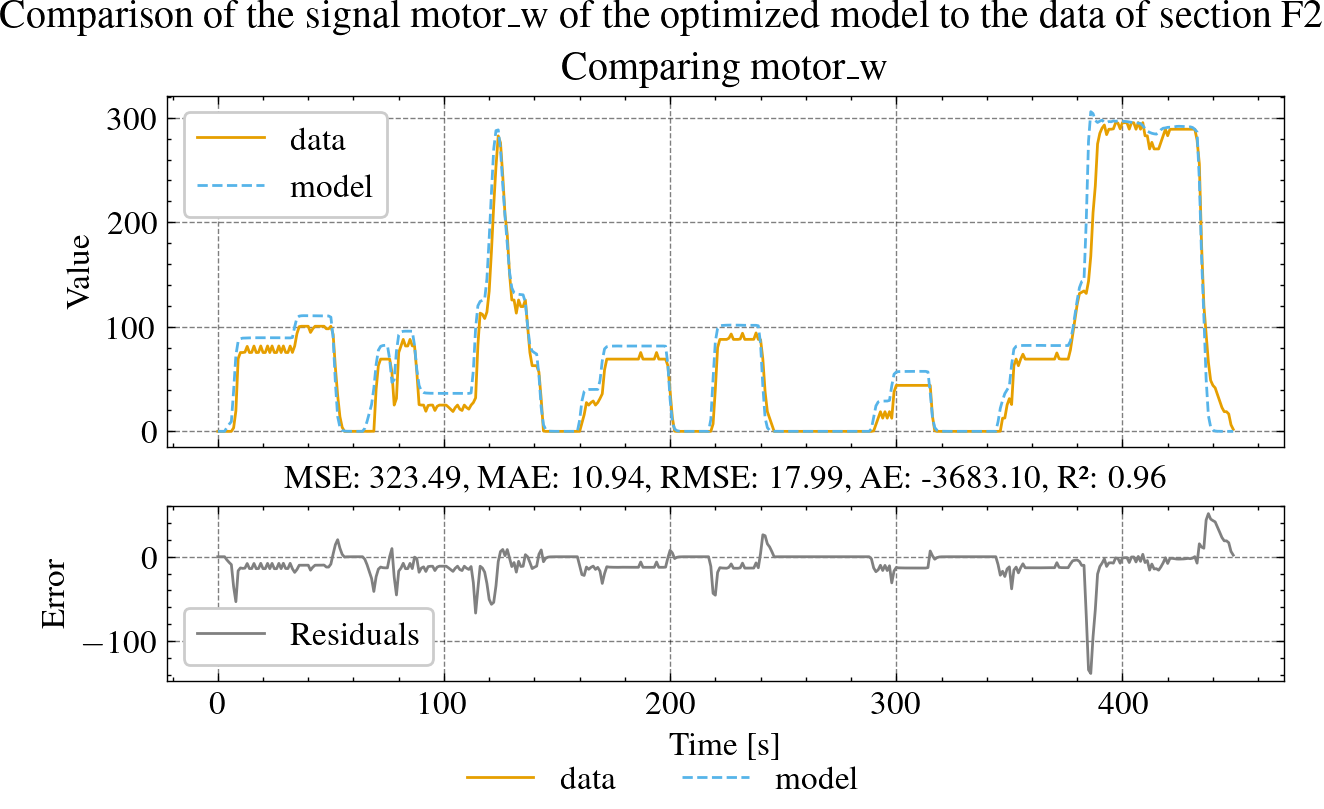

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f2_opt_all.pdf


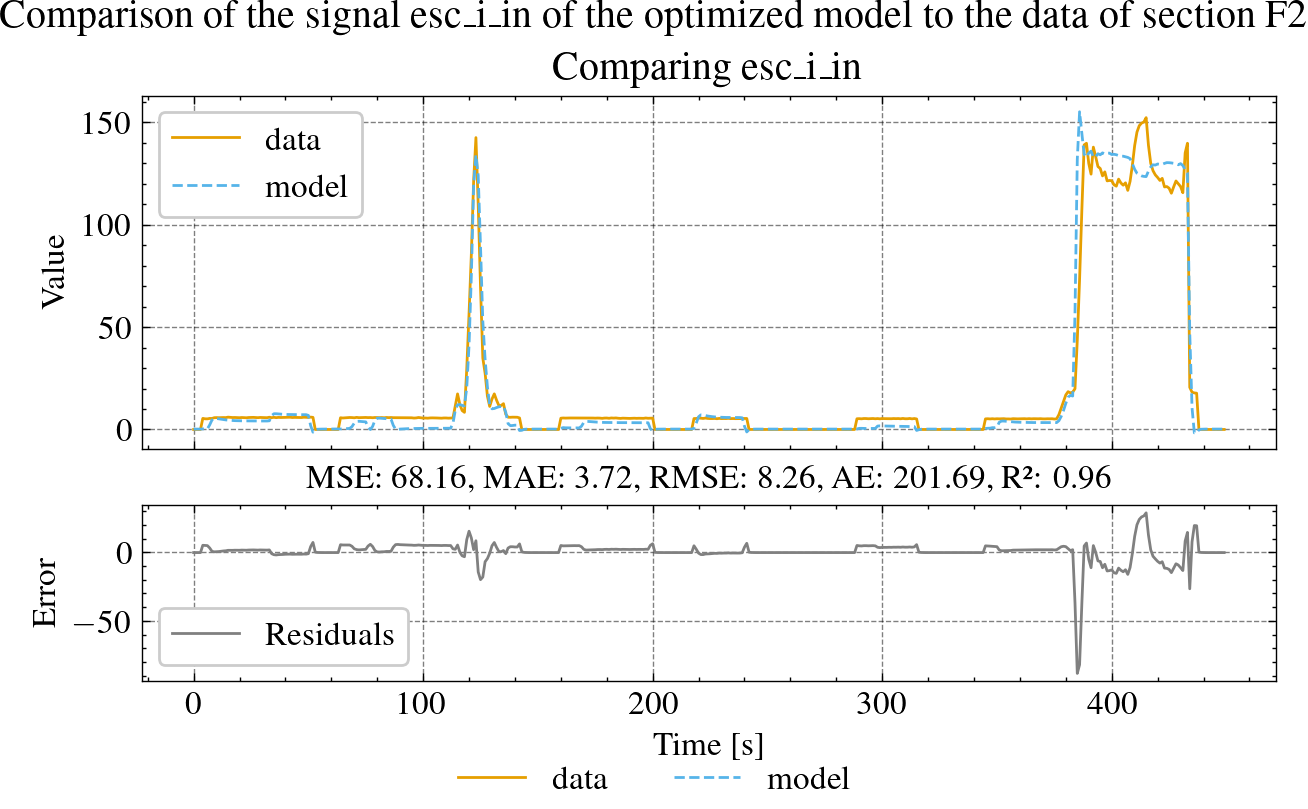

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f2_opt_all.pdf


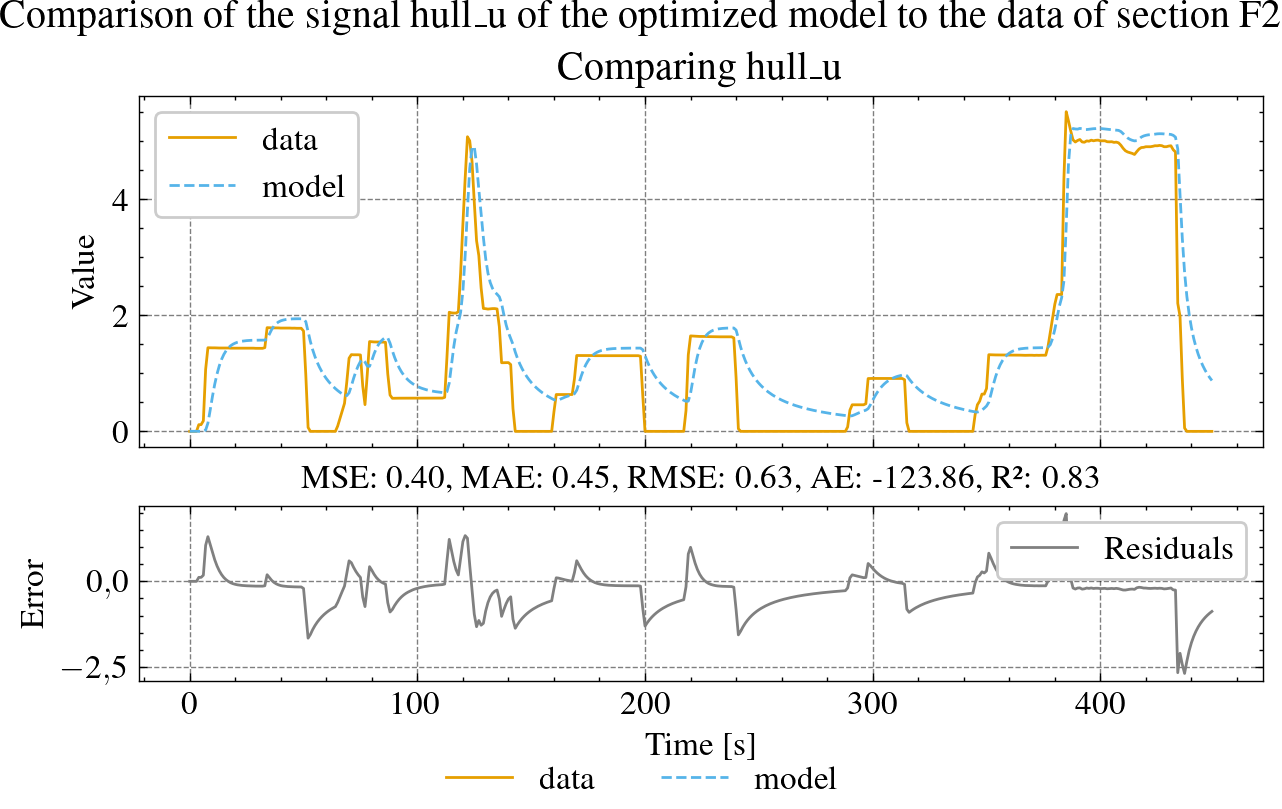

In [69]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(propulsion_params | best_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:propulsion_optimization_metrics_table_opt_all",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/propulsion_optimization_metrics_table_opt_all.tex", "w") as f:
    f.write(metrics_table_latex)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(propulsion_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/propulsion_optimization_test_residuals_{col}_test_{section_name.lower()}_opt_all.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [70]:
from utils.plot import plot_efficiency_map_scattered
from utils.control import get_steady_state_map

In [71]:
set(Propulsion.build({}).output_labels + Propulsion.build({}).input_labels + Propulsion.build({}).state_labels)

{'batt_v',
 'esc_d',
 'esc_i_in',
 'hull_r',
 'hull_u',
 'motor_i',
 'motor_q_load',
 'motor_v',
 'motor_w',
 'pilot_d',
 'prop_J',
 'prop_k_T',
 'prop_k_q',
 'prop_q',
 'prop_t',
 'prop_w'}

In [72]:
def model_function(T, U, X0, **params) -> pd.DataFrame:
    resp = ct.input_output_response(
        Propulsion.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method='Radau',
    ).to_pandas()
    
    # Params
    hull_T_ded = params['hull_T_ded']
    hull_W = params['hull_W']

    # Signals
    motor_v = np.asarray(resp['motor_v'], float)
    motor_q_load = np.asarray(resp['motor_q_load'], float)
    motor_i = np.asarray(resp['motor_i'], float)
    motor_w = np.asarray(resp['motor_w'], float)
    esc_i_in =  np.asarray(resp['esc_i_in'], float)
    esc_v_in = np.asarray(resp['batt_v'], float)
    hull_r = np.asarray(resp['hull_r'], float)
    hull_u = np.asarray(resp['hull_u'], float)
    prop_w = np.asarray(resp['prop_w'], float)
    prop_q = np.asarray(resp['prop_q'], float)
    prop_t = np.asarray(resp['prop_t'], float)

    # Motor
    motor_p_in = motor_v * motor_i
    motor_p_out = motor_w * motor_q_load
    motor_eta = np.ma.masked_invalid(motor_p_out / motor_p_in)
    resp['motor_p_in'] = motor_p_in
    resp['motor_p_out'] = motor_p_out
    resp['motor_eta'] = motor_eta

    # ESC
    esc_i_out =  motor_i
    esc_v_out = motor_v
    esc_p_in = esc_i_in * esc_v_in
    esc_p_out = esc_i_out * esc_v_out
    esc_eta = esc_p_out / esc_p_in
    resp['esc_p_in'] = esc_p_in
    resp['esc_p_out'] = esc_p_out
    resp['esc_eta'] = esc_eta

    # Hull
    hull_r_t = hull_r* (1 - hull_T_ded)
    hull_p_out = hull_r_t * hull_u
    hull_t = prop_t
    hull_p_in = hull_t * hull_u
    hull_eta = hull_p_out / hull_p_in
    resp['hull_p_in'] = hull_p_in
    resp['hull_p_out'] = hull_p_out
    resp['hull_eta'] = hull_eta

    # Prop
    prop_p_in = prop_w * prop_q
    prop_u = hull_u * (1 - hull_W)
    prop_p_out = prop_t * prop_u
    prop_eta = prop_p_out / prop_p_in
    resp['prop_p_in'] = prop_p_in
    resp['prop_p_out'] = prop_p_out
    resp['prop_eta'] = prop_eta

    # Trans
    trans_w_in = motor_w
    trans_w_out = prop_w
    trans_q_in = motor_q_load
    trans_q_out = prop_q
    trans_p_in = trans_w_in * trans_q_in
    trans_p_out = trans_w_out * trans_q_out
    trans_eta = trans_p_out / trans_p_in
    resp['trans_p_in'] = trans_p_in
    resp['trans_p_out'] = trans_p_out
    resp['trans_eta'] = trans_eta

    resp['propulsive_eta'] = hull_p_out / esc_p_in
    resp['propulsive_electrical_eta'] = motor_p_out / esc_p_in
    resp['propulsive_mechanical_eta'] = hull_p_out / prop_p_in

    return resp


Y_ss = get_steady_state_map(
    model_class=Propulsion,
    model_function=model_function,
    model_params=propulsion_params | best_params,
    sweep_bounds={
        'batt_v': dict(min=36, max=36),
        'pilot_d': dict(min=0, max=1),
    },
    sweep_steps=100,
    dt=1,
    ss_len=10,
    ss_tail_len=2,
)

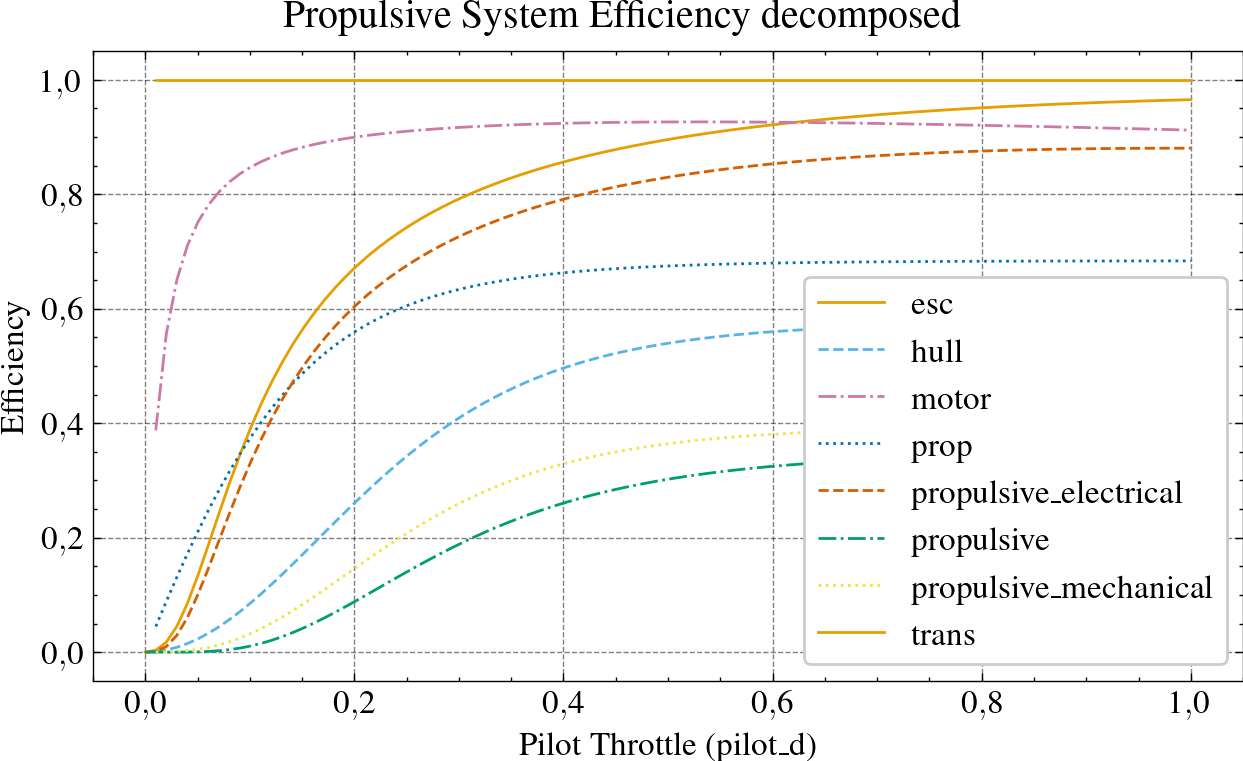

In [73]:
eta_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_eta')]))

Y_ss2 = Y_ss.copy().groupby('pilot_d').mean().reset_index()
for eta_col in eta_cols:
    plt.plot(Y_ss2['pilot_d'], Y_ss2[eta_col], label=eta_col[:-4])

plt.xlabel('Pilot Throttle (pilot_d)')
plt.ylabel('Efficiency')
plt.suptitle('Propulsive System Efficiency decomposed')
plt.legend()
plt.show()

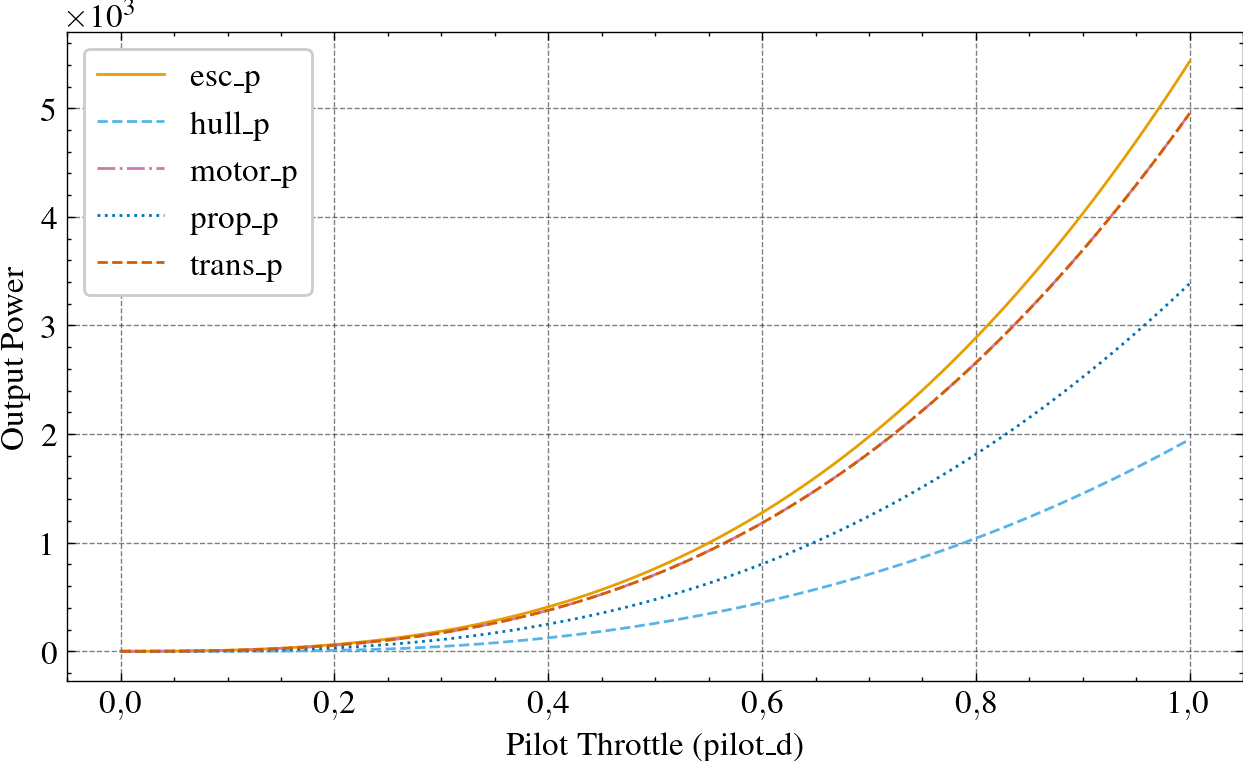

In [74]:
p_out_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_p_out')]))

Y_ss2 = Y_ss.copy().groupby('pilot_d').mean().reset_index()
for p_out_col in sorted(p_out_cols):
    plt.plot(Y_ss2['pilot_d'], Y_ss2[p_out_col], label=p_out_col[:-4])

plt.xlabel('Pilot Throttle (pilot_d)')
plt.ylabel('Output Power')
plt.legend()
plt.show()


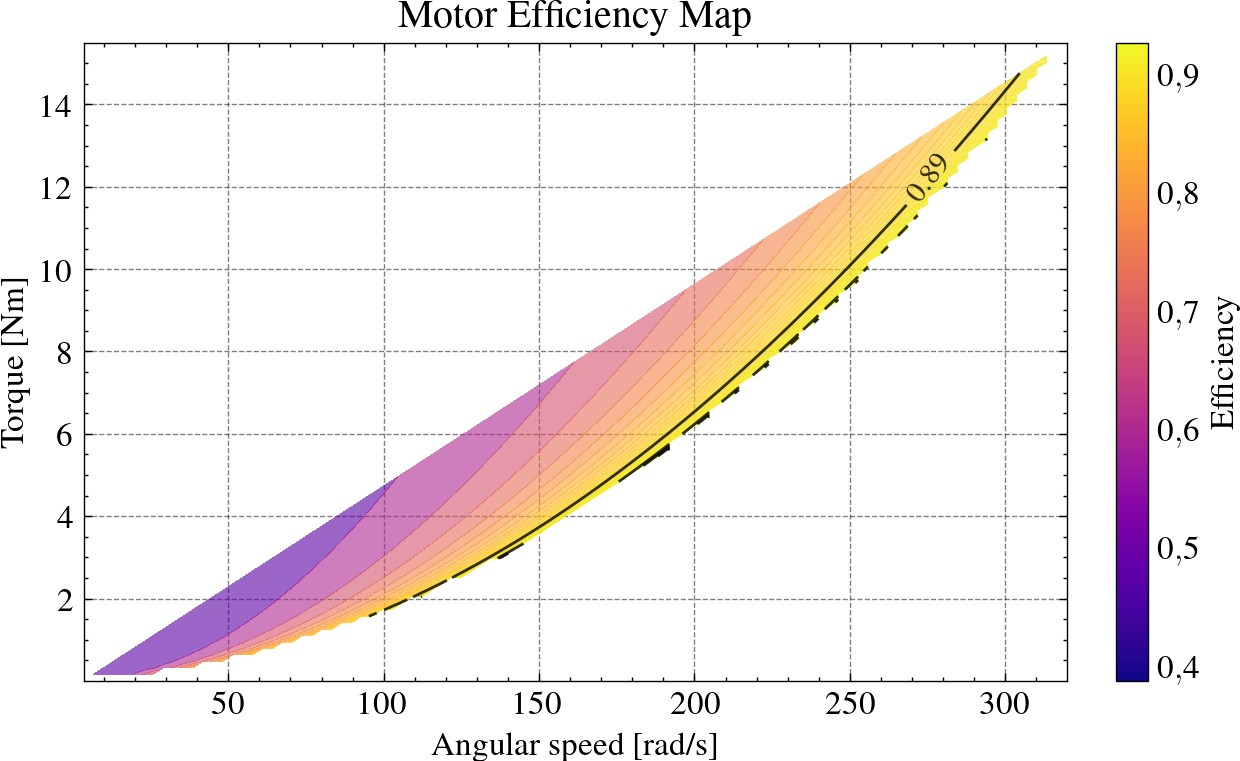

In [75]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='motor_eta',
    nx=100, ny=100,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=95, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Motor Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

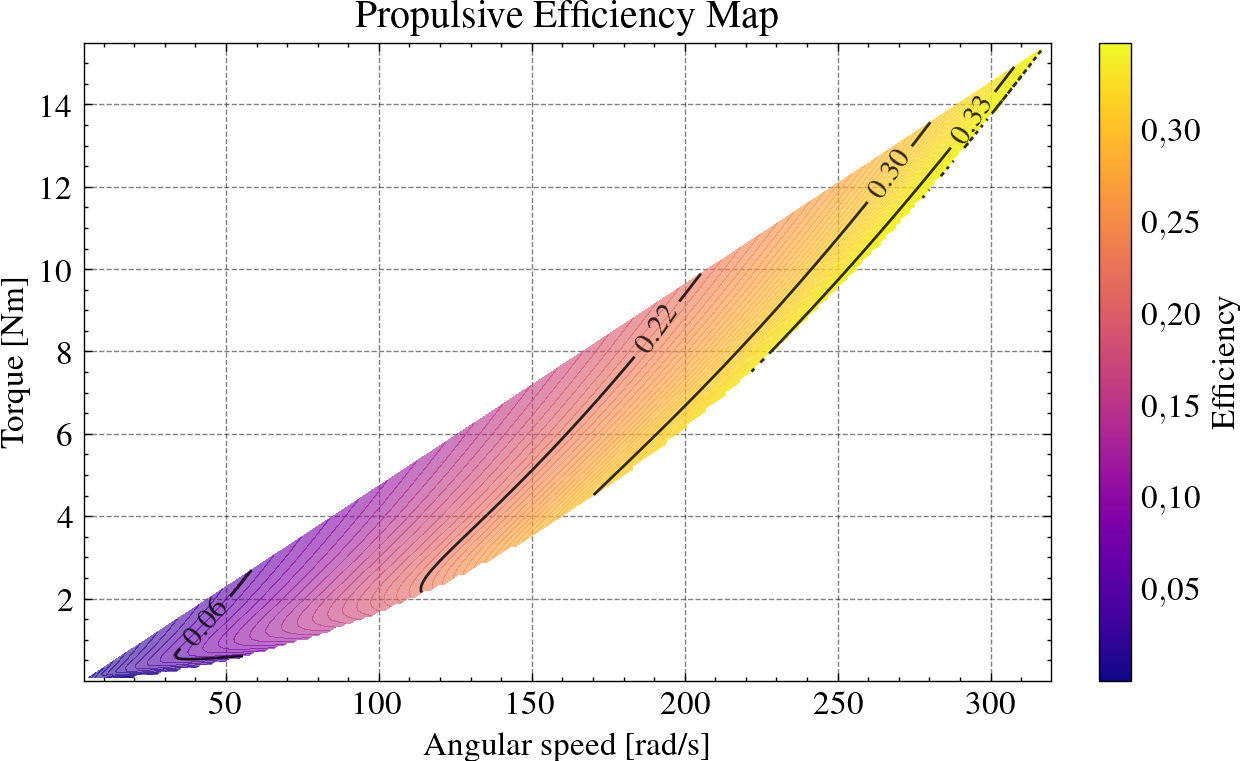

In [76]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

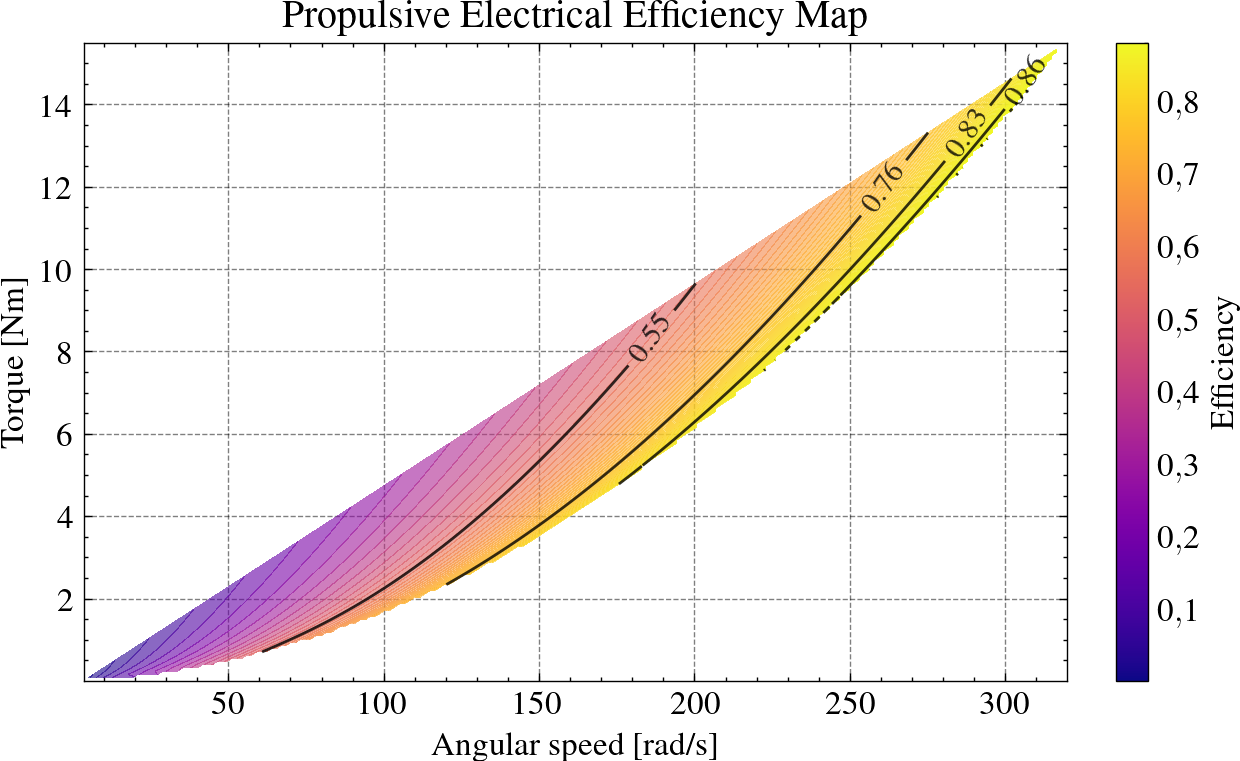

In [77]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_electrical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Electrical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

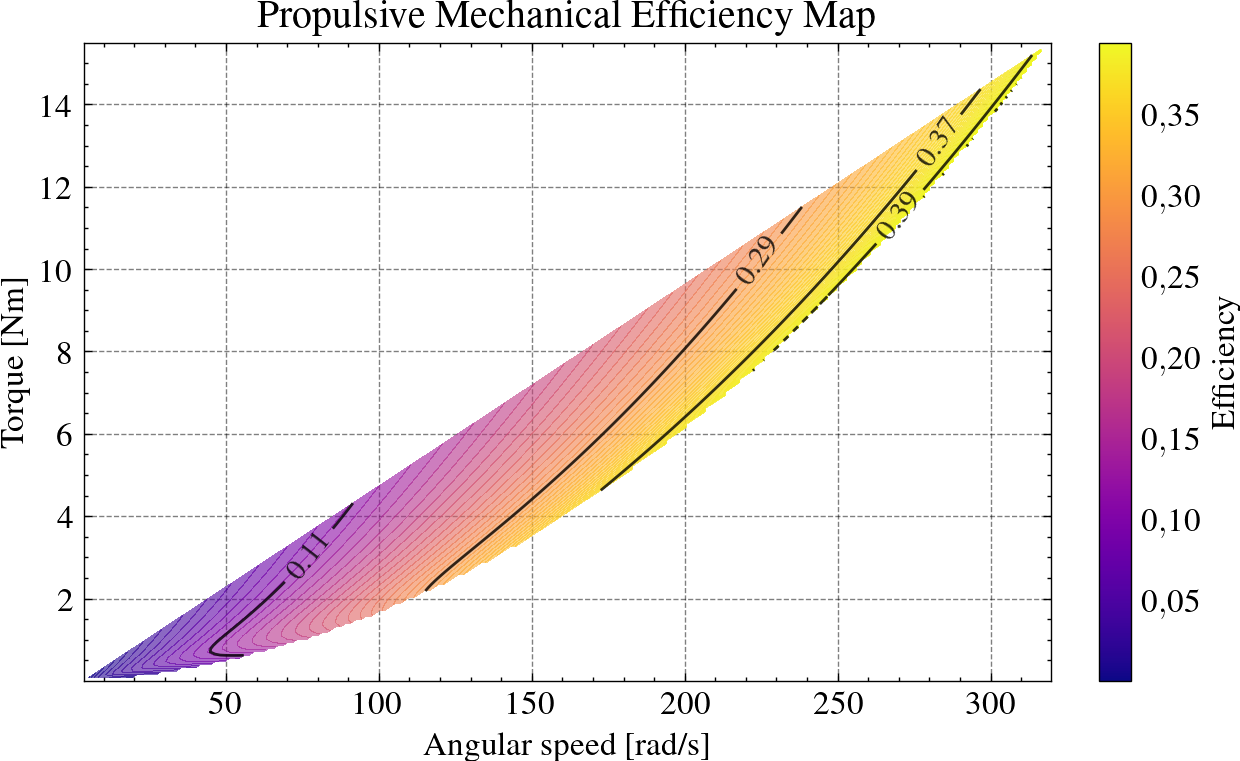

In [78]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_mechanical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Mechanical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

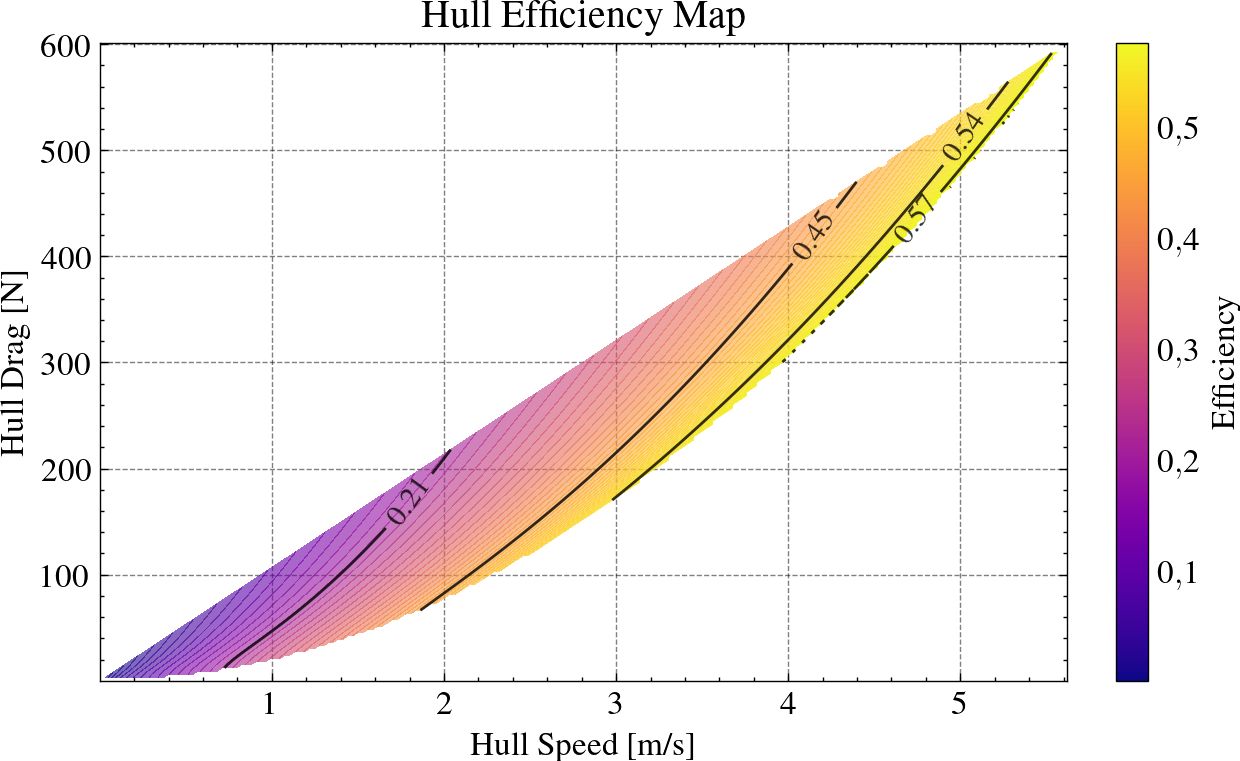

In [79]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='hull_u', y='hull_r', z='hull_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Hull Efficiency Map',
    xlabel='Hull Speed [m/s]',
    ylabel='Hull Drag [N]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

Text(0, 0.5, 'Propeller Advance Ratio (J)')

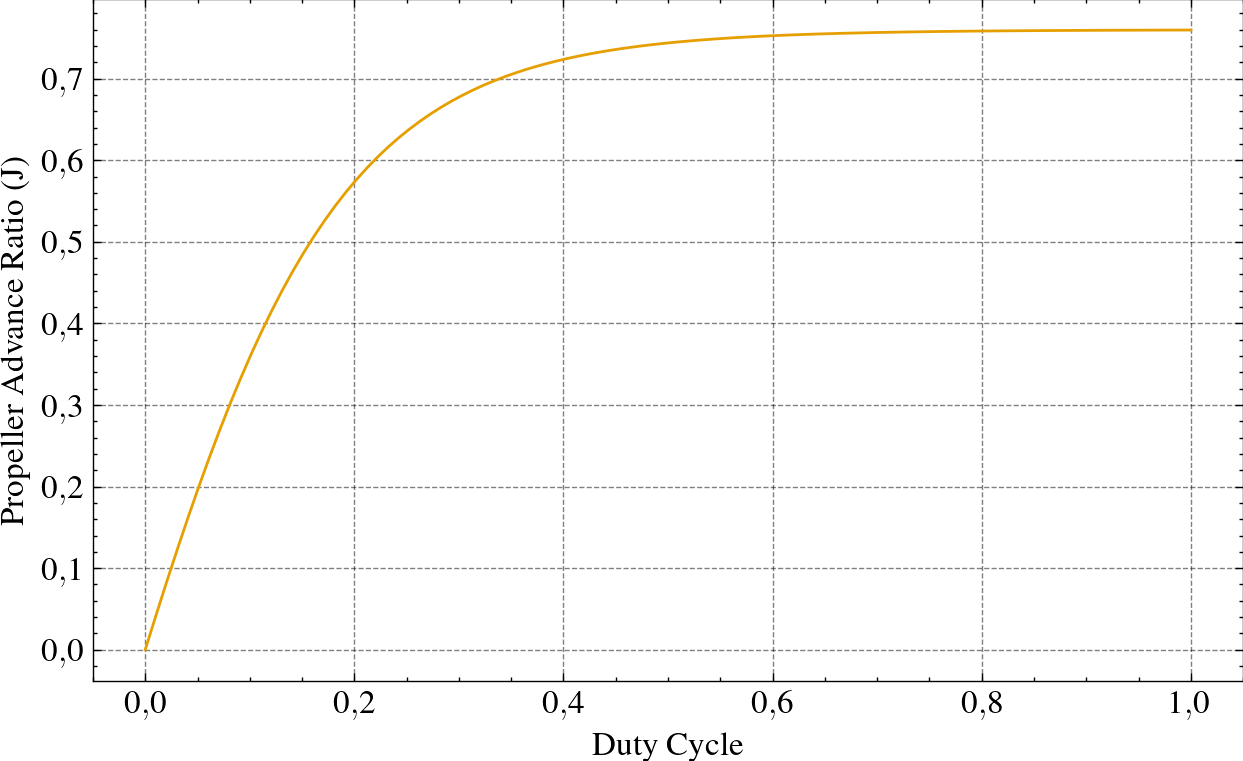

In [80]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_J'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Advance Ratio (J)')

Text(0, 0.5, 'Hull speed [m/s]')

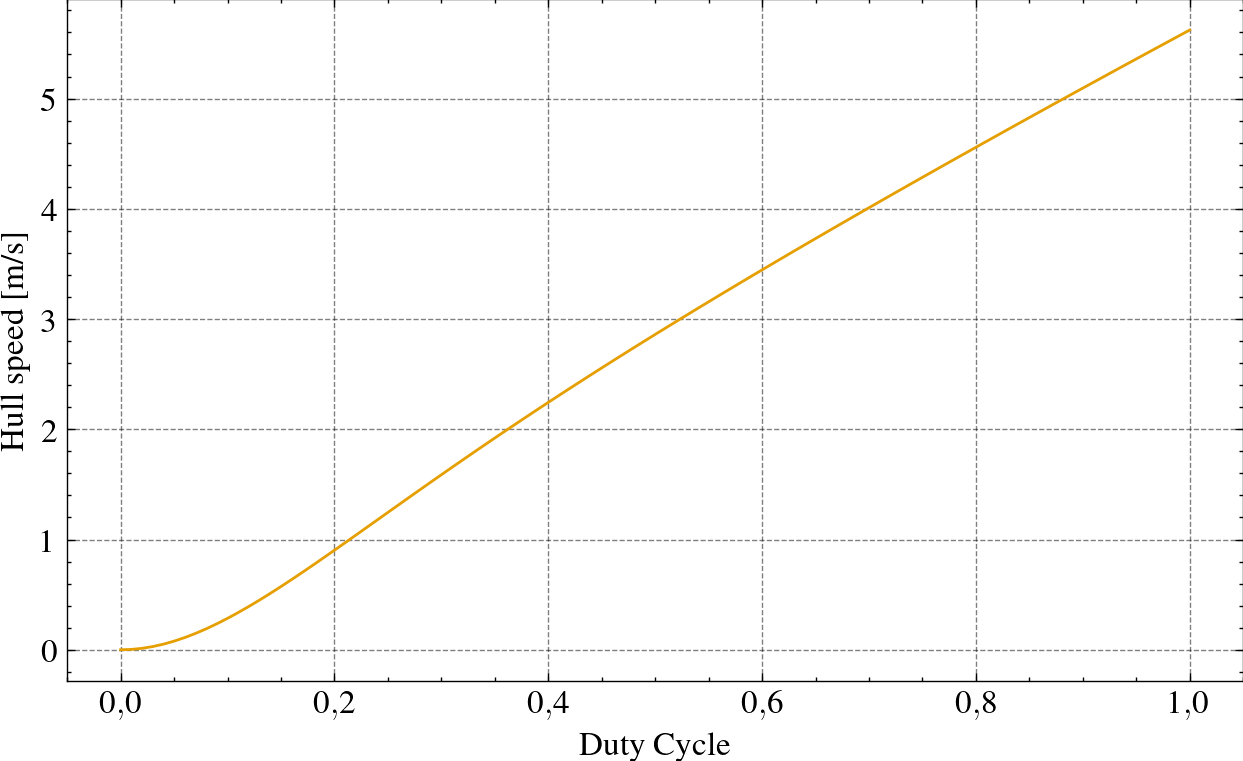

In [81]:
plt.plot(Y_ss2['esc_d'], Y_ss2['hull_u'])
plt.xlabel('Duty Cycle')
plt.ylabel('Hull speed [m/s]')

Text(0, 0.5, 'Propeller Angualr speed [rad/s]')

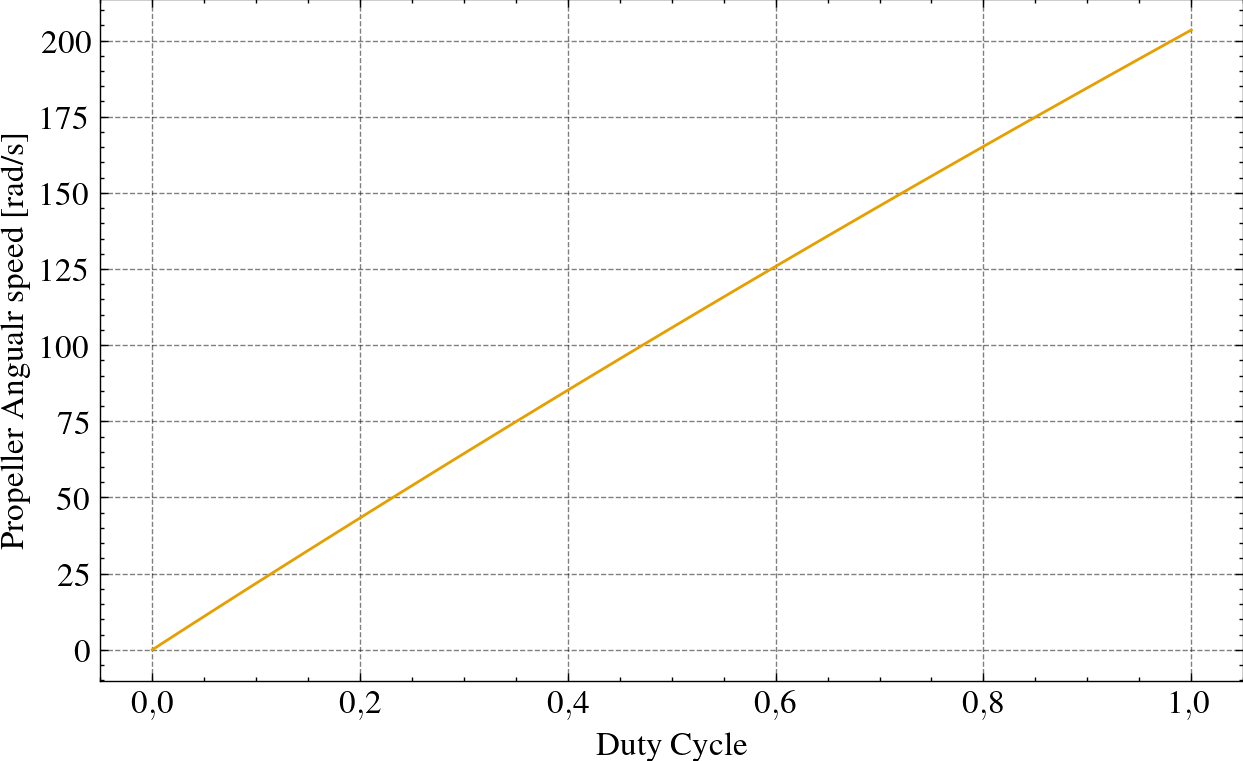

In [82]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_w'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Angualr speed [rad/s]')

Text(0.5, 0, 'Propeller Angualr speed [rad/s]')

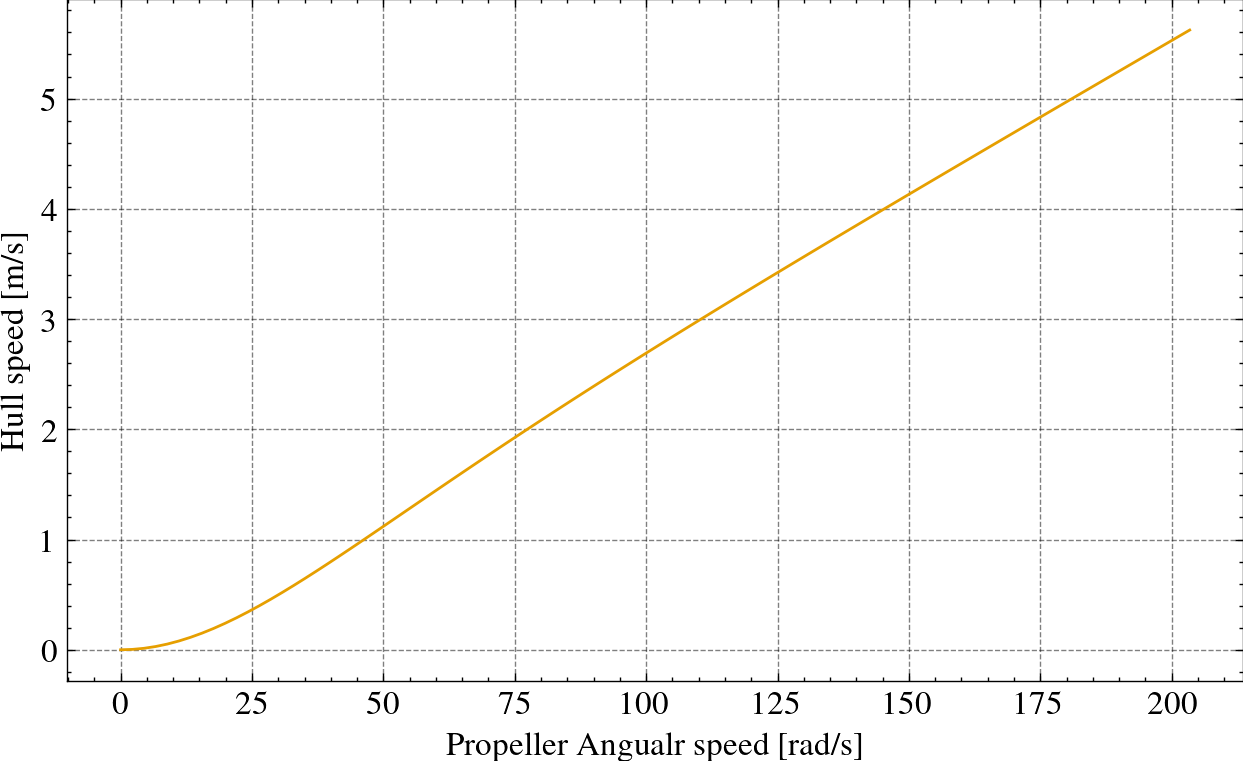

In [83]:
plt.plot(Y_ss2['prop_w'], Y_ss2['hull_u'])
plt.ylabel('Hull speed [m/s]')
plt.xlabel('Propeller Angualr speed [rad/s]')